In [389]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
from datetime import datetime
import datetime
import time
import timestring
import math
matplotlib.rcParams['figure.figsize'] = (14, 8)

Bring all the data into a single dataframe.
Sample of the data is located in the Google Drive folder (link below). One zip file for each month for the year of 2017
https://drive.google.com/drive/folders/1lZJhPM24i9PQRW_nOTQj5sQy3FTiwhbY?usp=sharing


In [8]:
path = './Data/AirlineData/2017/'
all_files = glob.glob(os.path.join(path, "*.zip"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, compression='zip', parse_dates=['FL_DATE']) for f in all_files)
concatenated_df = pd.concat(df_from_each_file)

In [9]:
concatenated_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5674621 entries, 0 to 410516
Data columns (total 33 columns):
YEAR                   int64
MONTH                  int64
DAY_OF_MONTH           int64
DAY_OF_WEEK            int64
FL_DATE                datetime64[ns]
OP_CARRIER             object
ORIGIN                 object
ORIGIN_CITY_NAME       object
ORIGIN_STATE_ABR       object
DEST                   object
DEST_CITY_NAME         object
DEST_STATE_ABR         object
CRS_DEP_TIME           int64
DEP_TIME               float64
DEP_DELAY              float64
DEP_DELAY_NEW          float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME           int64
ARR_TIME               float64
ARR_DELAY              float64
ARR_DELAY_NEW          float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
N

In [10]:
#define a function to find memory usage 
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

# Get all the int-type data

In [11]:
df_int = concatenated_df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

303.06 MB
92.00 MB


# Get all the float-type data

In [12]:
df_float = concatenated_df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

865.88 MB
454.59 MB


# Create an optimized copy of df

In [13]:
optimized_df = concatenated_df.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(concatenated_df))
print(mem_usage(optimized_df))

3533.38 MB
2911.03 MB


# Get all the object-type data

In [14]:
df_obj = concatenated_df.select_dtypes(include=['object']).copy()

In [15]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]
        
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

2407.74 MB
102.95 MB


In [16]:
optimized_df[converted_obj.columns] = converted_obj
mem_usage(optimized_df)

'606.25 MB'

In [17]:
optimized_df.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 32'],
      dtype='object')

# Clean up the data

In [18]:
optimized_df = optimized_df.drop(['Unnamed: 32'], axis=1)

In [19]:
#remove rows will null values which is approximately 1.5%
null_columns = optimized_df.columns[optimized_df.isnull().any()]
optimized_df[null_columns].isnull().sum()

DEP_TIME                 80308
DEP_DELAY                80343
DEP_DELAY_NEW            80343
TAXI_OUT                 82145
WHEELS_OFF               82141
WHEELS_ON                84674
TAXI_IN                  84674
ARR_TIME                 84674
ARR_DELAY                95211
ARR_DELAY_NEW            95211
ACTUAL_ELAPSED_TIME      95211
AIR_TIME                 95211
CARRIER_DELAY          4645148
WEATHER_DELAY          4645148
NAS_DELAY              4645148
SECURITY_DELAY         4645148
LATE_AIRCRAFT_DELAY    4645148
dtype: int64

In [20]:
optimized_df = optimized_df.dropna(subset=['DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

# Creating a new column with departure date and time

In [41]:
#since the DEP_TIME is presented as a float we need to convert it to a Timestamp
def convert_to_time (datatype):
    '''This method will take a float as input and returns a datetime.time object'''
    to_string = str(int(datatype))
    #check length of string and add leading zeros if lenght is less than 4
    while len(to_string) < 4:
        to_string = '0' + to_string
    #check if hour starts with 24 then change to 00
    if to_string[:2] == '24':
        to_string = '00' + to_string[2:]
    obj = time.strptime(to_string, '%H%M')
    
    #to_string = to_string[:2] + ':' + to_string[2:] 
    #datetime = pd.to_datetime(to_string)
    #datetime = pd.to_datetime(to_string, format='%H:%M')
    #time = datetime.time()
    #return time
    
    datetime = time.strftime("%H:%M", obj)
    return datetime

In [42]:
#Apply the method to the DEP_TIME column to convert it to a Timestamp
optimized_df['DEP_TIME_TIME'] = optimized_df.DEP_TIME.apply(convert_to_time)

In [21]:
#We now need to create a new Timestamp column incorporating the information from FL_DATE and DEP_TIME
def combine_datetime (dataframe):
    '''This function will extract needed data from two columns and combine into a single Timestamp object'''
    year = dataframe[0].year
    month = dataframe[0].month
    day = dataframe[0].day
    hour = dataframe[1].hour
    minute = dataframe[1].minute
    second = dataframe[1].second
    
    datetime = pd.Timestamp(year, month, day, hour, minute, second)
    return datetime

In [22]:
combined = optimized_df[['FL_DATE','DEP_TIME']]

In [23]:
combined.head()

,FL_DATE,DEP_TIME
0,2017-03-21,2019-03-30 10:31:00
1,2017-03-21,2019-03-30 14:20:00
2,2017-03-21,2019-03-30 12:03:00
3,2017-03-21,2019-03-30 07:58:00
4,2017-03-21,2019-03-30 10:41:00


In [24]:
#apply the combine_datetime function to optimized_df and create a new column 'FL_TIME'
optimized_df['FL_TIME'] = combined.apply(combine_datetime, axis=1)

In [104]:
def time_to_float(time):
    '''This function will convert time that is incorrectly represented into a float
    for easier plotting with matplotlib'''
    if len(str(int(time))) > 2:
        denom = time / 2400.0
        numer = (float(str(int(time))[:-2:]) + float(str(int(time))[-2:])/60)/24
        ratio = numer / denom
        time_float = time * ratio
    else:
        time_float = time / 60 * 100
    
    return time_float

# Import two more csv files for reference

In [296]:
#Airport location for geographical analysis
airport_location = pd.read_csv('airport_loc.csv')

In [297]:
airport_location.head()

,locationID,Latitude,Longitude
0,ADK,51.8781,176.6461
1,AKK,56.9386,154.1825
2,Z13,60.9047,161.4225
3,AKI,60.9028,161.2306
4,AUK,62.6800,164.6600


In [298]:
#combine Latitude and Longitude into a tuple and form a new column and drop the Latitude & Longitude columns
airport_location['location'] = list(zip(airport_location.Latitude, airport_location.Longitude))
airports = airport_location.copy()
airports.head()
airports.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
airports.head(3)

,locationID,location
0,ADK,"(51.8781, 176.6461)"
1,AKK,"(56.9386, 154.1825)"
2,Z13,"(60.9047, 161.4225)"


In [304]:
airport_loc = airports.set_index('locationID').to_dict()

In [308]:
airport_loc = airport_loc['location']

In [309]:
airport_loc.get('ATL')

(33.6367, 84.4281)

In [136]:
#Airline codes with names for cleaner presentation
airline_codes = pd.read_csv('L_CARRIER_HISTORY.csv')

In [137]:
airline_codes.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [138]:
airline_dict = airline_codes.set_index('Code').to_dict()

In [139]:
airline_dict = airline_dict['Description']

#  

# EDA

# Initial look at the data

In [483]:
#Calculate the actual trip time using taxi times and actual flight time
trip_time = optimized_df.TAXI_OUT / 60 + optimized_df.ACTUAL_ELAPSED_TIME / 60 + optimized_df.TAXI_IN / 60 

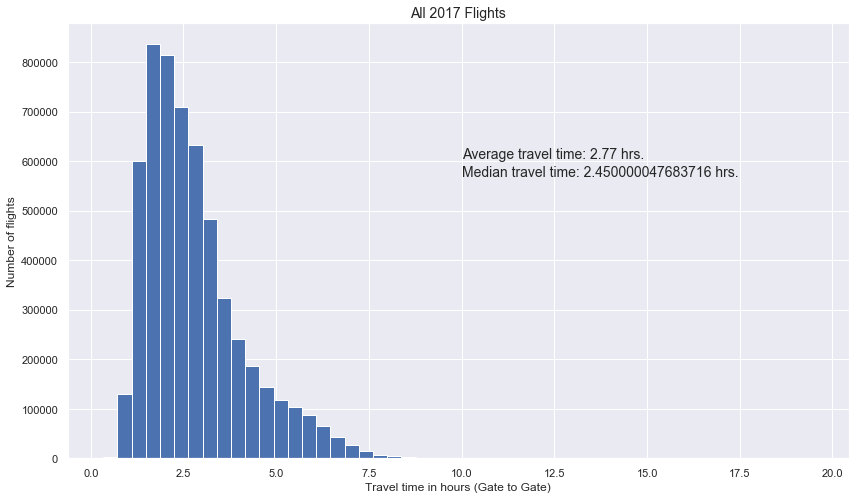

In [787]:
trip_time.hist(bins=50)
plt.xlabel('Travel time in hours (Gate to Gate)')
plt.ylabel('Number of flights')
plt.title('All 2017 Flights', fontsize=14)
plt.text(10, 605000, f"Average travel time: {round(trip_time.mean(),2)} hrs.", fontsize=14)
plt.text(10, 570000, f"Median travel time: {(np.median(trip_time))} hrs.", fontsize=14)
plt.show()

In [600]:
#all arrival delays
delays = optimized_df[optimized_df.ARR_DELAY > 0]
#arrival delays more than 15 minutes
delays_15 = optimized_df[optimized_df.ARR_DELAY > 15]
#arrival delays longer than 4 hrs
delay_4hr = optimized_df[optimized_df.ARR_DELAY / 60 >=4]
#arrival delays more than 15mins and less than 4 hrs
delay_15_4 = optimized_df[(optimized_df.ARR_DELAY / 60 < 4) & (optimized_df.ARR_DELAY > 15)]

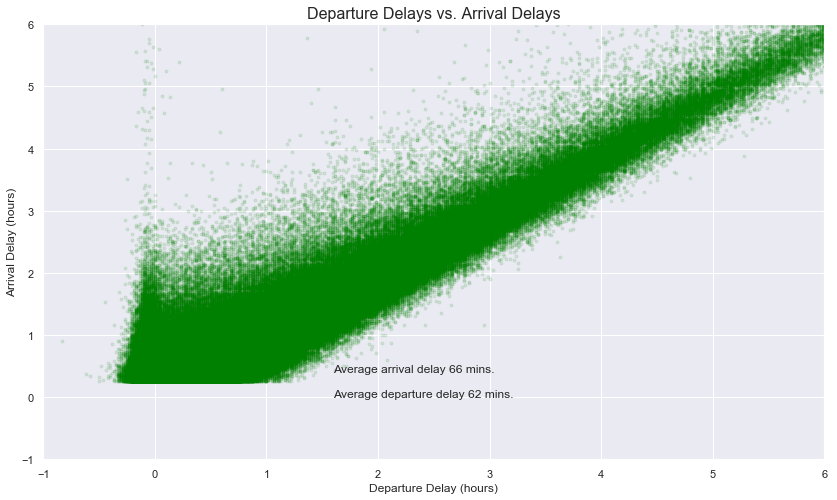

In [871]:
plt.plot(delays_15.DEP_DELAY / 60, delays_15.ARR_DELAY / 60, marker='.', linestyle='None', alpha = 0.1, color='green')
plt.xlim([-1, 6])
plt.ylim([-1, 6])
plt.xlabel('Departure Delay (hours)')
plt.ylabel('Arrival Delay (hours)')
plt.text(1.6, 0, f"Average departure delay {round((delays_15.DEP_DELAY).mean())} mins.")
plt.text(1.6, 0.4, f"Average arrival delay {round((delays_15.ARR_DELAY).mean())} mins.")
plt.title('Departure Delays vs. Arrival Delays', fontsize=16)
plt.show()

### There is a distinct linear relationship between departure delay and arrival delay, which makes sense. This means  we can also analyze departure delays and causes to predict arrival delays. We also see a small spike around the area of early departure or on time departure but late arrival, which is also worth investigating.

In [597]:
(delays_15.YEAR.value_counts() / optimized_df.YEAR.value_counts() * 100)

2017    17.787185
Name: YEAR, dtype: float64

17% of all flights are delayed by more than 15 minutes.

In [493]:
delay_4hr.YEAR.value_counts() / delays.YEAR.value_counts() * 100

2017    1.453295
Name: YEAR, dtype: float64

Less than 1.5% of all DELAYED flights are delayed by more than 4 hours

Text(10, 305000, 'Percent of delays longer than 15 mins.: 2017    17.79\nName: YEAR, dtype: float64 ')

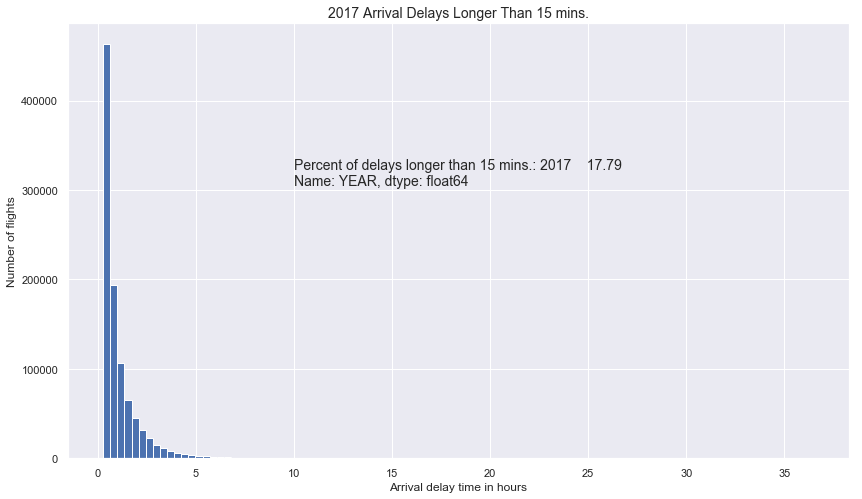

In [785]:
delay_15 = delays_15.ARR_DELAY / 60
delay_15.hist(bins=100)
plt.xlabel('Arrival delay time in hours')
plt.ylabel('Number of flights')
plt.title('2017 Arrival Delays Longer Than 15 mins.',fontsize=14)
plt.text(10, 305000, f"Percent of delays longer than 15 mins.: \
{round((delays_15.YEAR.value_counts() / optimized_df.YEAR.value_counts() * 100),2)} ", fontsize=14)

Text(0.5, 1.0, '2017 Arrival Delay Between 15min. and 4hrs.')

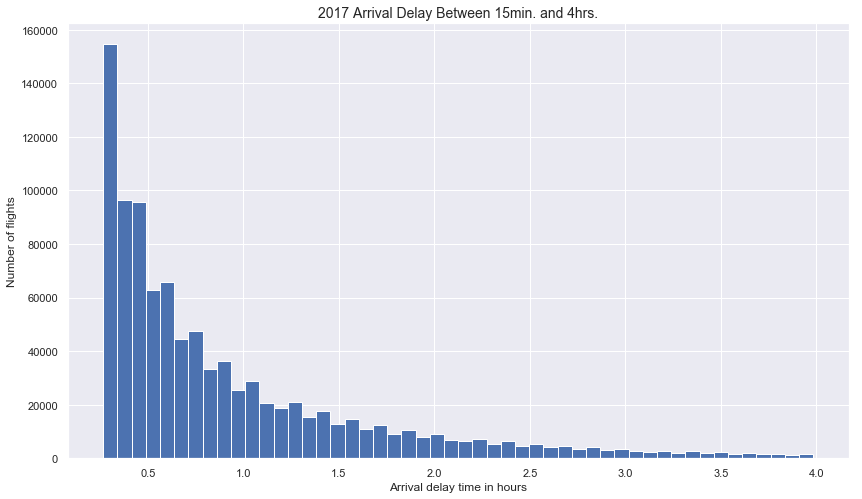

In [786]:
delay_4_arr = delay_15_4.ARR_DELAY / 60
delay_4_arr.hist(bins=50)
plt.xlabel('Arrival delay time in hours')
plt.ylabel('Number of flights')
plt.title('2017 Arrival Delay Between 15min. and 4hrs.', fontsize=14)

Text(0.5, 1.0, '2017 Arrival Delay Longer Than 4 Hours')

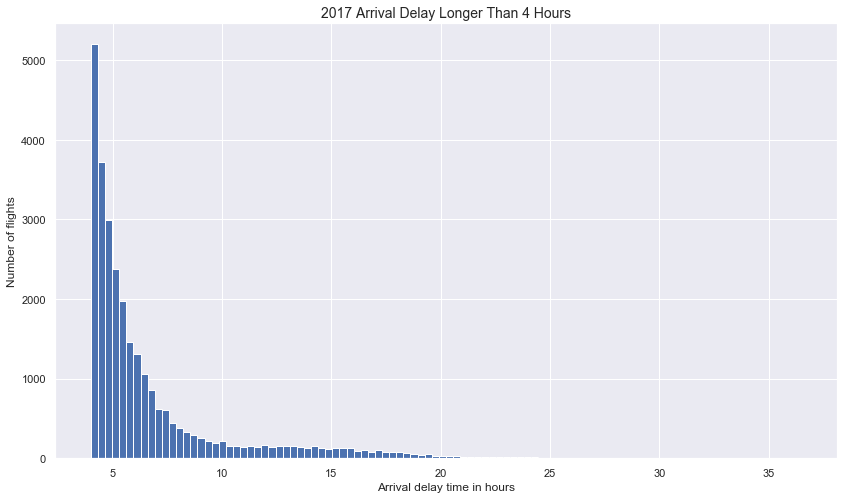

In [788]:
delay_4 = delay_4hr.ARR_DELAY / 60
delay_4.hist(bins=100)
plt.xlabel('Arrival delay time in hours')
plt.ylabel('Number of flights')
plt.title('2017 Arrival Delay Longer Than 4 Hours', fontsize=14)

In [1283]:
flights_by_carrier = optimized_df.groupby('OP_CARRIER').size().sort_index()
flights_by_carrier_del = delays_15.groupby('OP_CARRIER').size().sort_index()
percent_delay = flights_by_carrier_del / flights_by_carrier

In [1284]:
sorted_flights = flights_by_carrier.sort_values(ascending=False)
sorted_flights_del = flights_by_carrier_del.sort_values(ascending=False)

In [1291]:
####use the same index for all data
sorted_flights_del = sorted_flights_del.get(sorted_flights.index)
percent_delay = percent_delay.get(sorted_flights.index)

In [1296]:
percent_delay.sort_values(ascending=False)

OP_CARRIER
VX    0.277877
B6    0.257856
F9    0.201811
NK    0.196220
EV    0.195932
WN    0.192491
OO    0.179436
AA    0.176565
UA    0.163890
AS    0.157340
DL    0.130984
HA    0.106147
dtype: float64

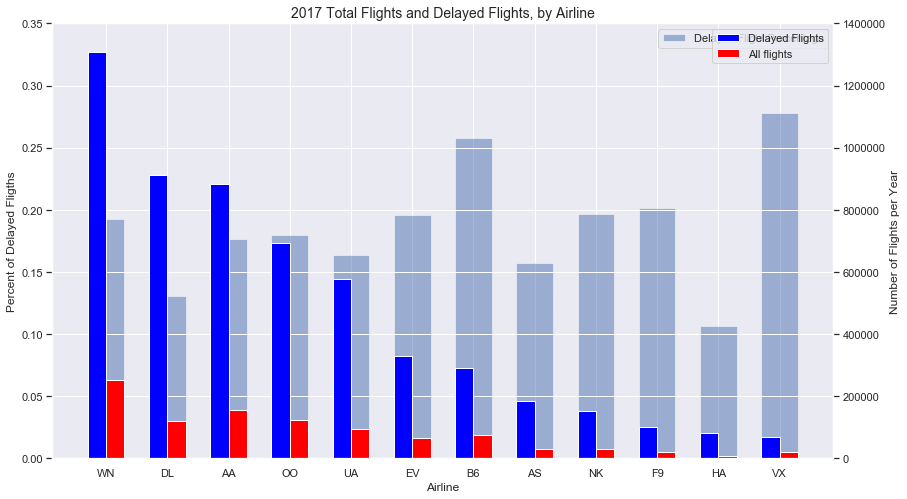

In [1295]:
ax = plt.subplot(111)
ax.bar(sorted_flights.index, percent_delay, width=0.6, align='center', alpha=0.5)
plt.xlabel('Airline')
plt.ylabel('Percent of Delayed Fligths')
plt.legend(['Delayed Flight Percentage'], loc='upper right')
plt.ylim(0,0.35)

ax2 = ax.twinx()
ax2.bar(sorted_flights.index, sorted_flights, width=-0.3, align='edge', color='blue')
ax2.bar(sorted_flights_del.index, sorted_flights_del, width=0.3, align='edge', color='red')
plt.legend(['Delayed Flights', 'All flights'])
plt.xlabel('Airline')
plt.ylabel('Number of Flights per Year')
plt.title('2017 Total Flights and Delayed Flights, by Airline', fontsize=14)
plt.ylim(0,1400000)
plt.show()

# EDA

# Carrier Performance Evaluation

Text(0, 0.5, 'Number of Delayed Flights')

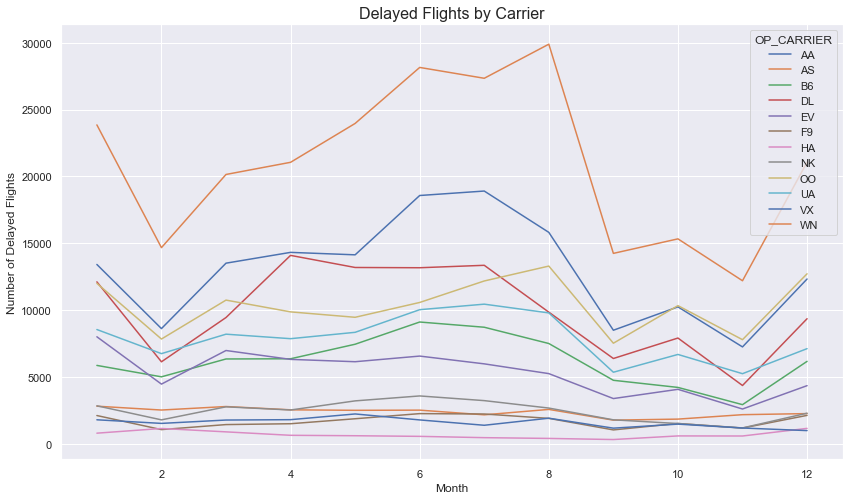

In [874]:
delays_15.groupby(['OP_CARRIER', 'MONTH']).size().unstack('OP_CARRIER').plot()
plt.title('Delayed Flights by Carrier', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Number of Delayed Flights')

Text(0, 0.5, 'Number of Flights')

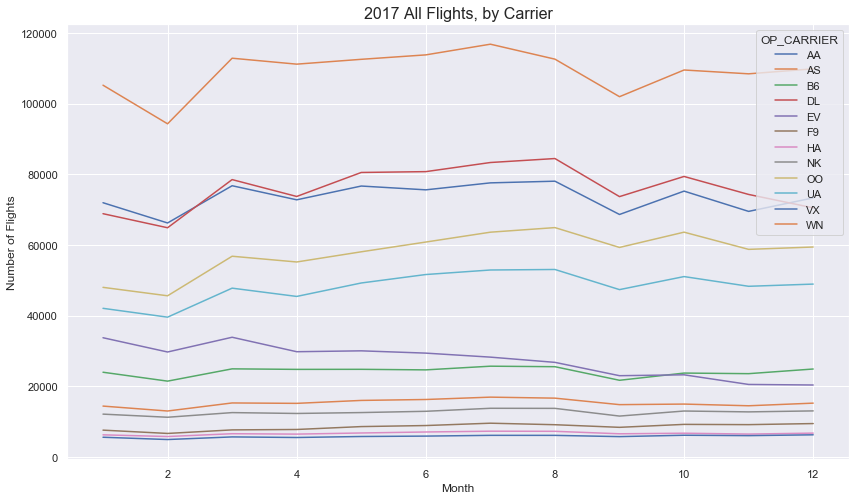

In [875]:
optimized_df.groupby(['OP_CARRIER', 'MONTH']).size().unstack('OP_CARRIER').plot()
plt.title('2017 All Flights, by Carrier', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Number of Flights')

# Southwest

In [605]:
#Let's break the above data down by airline.
#Most flights are by Southwest and they have a relatively high delay frequency
SouthWest = optimized_df[optimized_df.OP_CARRIER == 'WN']
SouthWest_del = delays_15[delays_15.OP_CARRIER == 'WN']

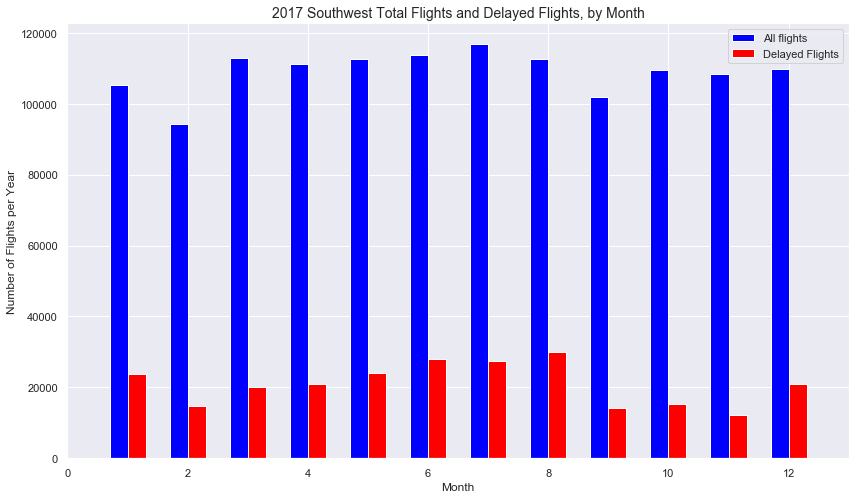

In [789]:
z = SouthWest.groupby('MONTH').size()
y = SouthWest_del.groupby('MONTH').size()
ax = plt.subplot(111)
ax.bar(z.index, z, width=-0.3, align='edge', color='blue')
ax.bar(y.index, y, width=0.3, align='edge', color='red')
plt.legend(['All flights', 'Delayed Flights'])
plt.xlabel('Month')
plt.ylabel('Number of Flights per Year')
plt.title('2017 Southwest Total Flights and Delayed Flights, by Month', fontsize=14)
plt.xlim(0,13)
plt.show()

In [1265]:
SouthWest_byOrigin = SouthWest.groupby('ORIGIN').size().sort_values(ascending=False)[0:60]
SouthWest_byOrigin_del = SouthWest_del.groupby('ORIGIN').size().sort_values(ascending=False)[0:60]

In [1266]:
testSW = SouthWest.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
testSW_del = SouthWest_del.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
ratioSW = testSW_del / testSW 
ratioSW = ratioSW.dropna(axis=0)
delay_ratioSW = ratioSW.get(SouthWest_byOrigin.index)

In [1272]:
####use the same index for all data
SouthWest_byOrigin_del = SouthWest_byOrigin_del.get(SouthWest_byOrigin.index)

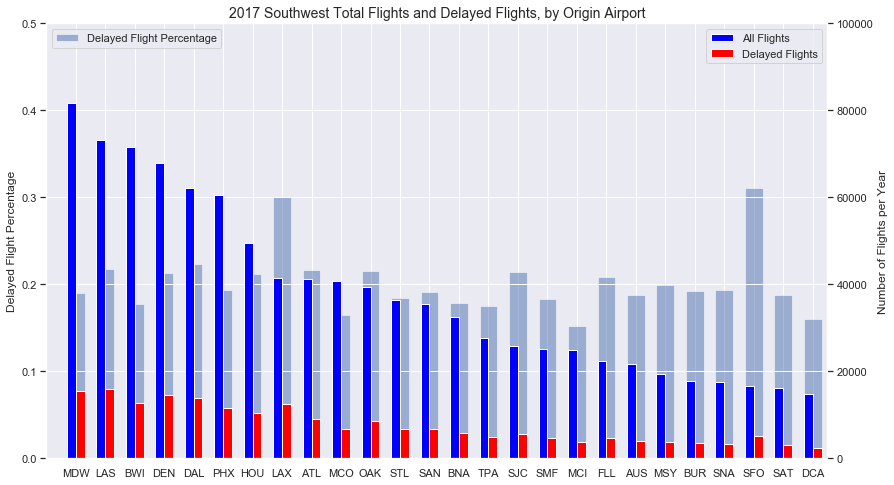

In [1271]:
ax = plt.subplot(111)
ax.bar(SouthWest_byOrigin.index, delay_ratioSW, width=0.6, align='center', alpha=0.5)
plt.legend(['Delayed Flight Percentage'], loc='upper left')
plt.ylabel('Delayed Flight Percentage')
plt.ylim(0,0.5)

ax2 = ax.twinx()
ax2.bar(SouthWest_byOrigin.index, SouthWest_byOrigin, width=-0.3, align='edge', color='blue')
ax2.bar(SouthWest_byOrigin_del.index, SouthWest_byOrigin_del, width=0.3, align='edge', color='red')
plt.legend(['All Flights', 'Delayed Flights'])
plt.xlabel('Origin Airport')
plt.ylabel('Number of Flights per Year')
plt.title('2017 Southwest Total Flights and Delayed Flights, by Origin Airport', fontsize=14)
plt.xlim(-1,25.5)
plt.ylim(0,100000)
plt.show()

## Looks like SFO and LAX are top of the list by percentage of delayed flights, this may have to do with airport layout and where Southwest is located...we can confirm this by looking at taxi times for Southwest vs other airlines. 

In [990]:
print(f'Southwest taxi out time for SFO: {round(SouthWest[SouthWest.ORIGIN == "SFO"]["TAXI_OUT"].mean(),2)} min.')
print(f'All airlines taxi out time for SFO: {round(optimized_df[optimized_df.ORIGIN == "SFO"]["TAXI_OUT"].mean(),2)} min.')

Southwest taxi out time for SFO: 18.18 min.
All airlines taxi out time for SFO: 21.47 min.


In [991]:
print(f'Southwest taxi out time for SFO: {round(SouthWest[SouthWest.ORIGIN == "LAX"]["TAXI_OUT"].mean(),2)} min.')
print(f'All airlines taxi out time for SFO: {round(optimized_df[optimized_df.ORIGIN == "LAX"]["TAXI_OUT"].mean(),2)} min.')

Southwest taxi out time for SFO: 13.95 min.
All airlines taxi out time for SFO: 18.98 min.


### Upon further investigation, it looks like all taxi times for LAX and SFO are relatively long, and Southwest actually performs better than the average.

#  

# American Airlines

In [1199]:
#Next let's take a look at American Airlines
American = optimized_df[optimized_df.OP_CARRIER == 'AA']
American_del = delays_15[delays_15.OP_CARRIER == 'AA']

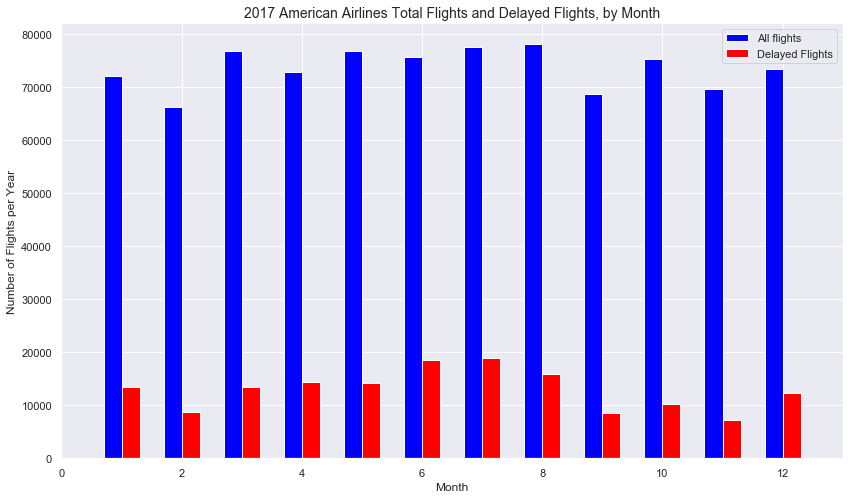

In [1200]:
z = American.groupby('MONTH').size()
y = American_del.groupby('MONTH').size()
ax = plt.subplot(111)
ax.bar(z.index, z, width=-0.3, align='edge', color='blue')
ax.bar(y.index, y, width=0.3, align='edge', color='red')
plt.legend(['All flights', 'Delayed Flights'])
plt.xlabel('Month')
plt.ylabel('Number of Flights per Year')
plt.title('2017 American Airlines Total Flights and Delayed Flights, by Month', fontsize=14)
plt.xlim(0,13)
plt.show()

In [1201]:
American_byOrigin = American.groupby('ORIGIN').size().sort_values(ascending=False)[0:60]
American_byOrigin_del = American_del.groupby('ORIGIN').size().sort_values(ascending=False)[0:60]

In [1202]:
testAA = American.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
testAA_del = American_del.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
ratioAA = testAA_del / testAA 
ratioAA = ratioAA.dropna(axis=0)
delay_ratioAA = ratioAA.get(American_byOrigin.index)

In [1273]:
####use the same index for all data
American_byOrigin_del = American_byOrigin_del.get(American_byOrigin.index)

In [1242]:
delay_ratioAA.sort_values(ascending=False)[0:20]

ORIGIN
JFK    0.239166
MIA    0.215648
PHL    0.215173
ORD    0.212090
DFW    0.207660
IAD    0.203976
SFO    0.197801
EWR    0.189142
CLT    0.184354
BOS    0.180293
LGA    0.178351
BNA    0.176712
MCO    0.175452
DCA    0.171743
RDU    0.168491
ATL    0.168249
LAX    0.166326
DEN    0.166208
DTW    0.163534
LAS    0.160894
dtype: float64

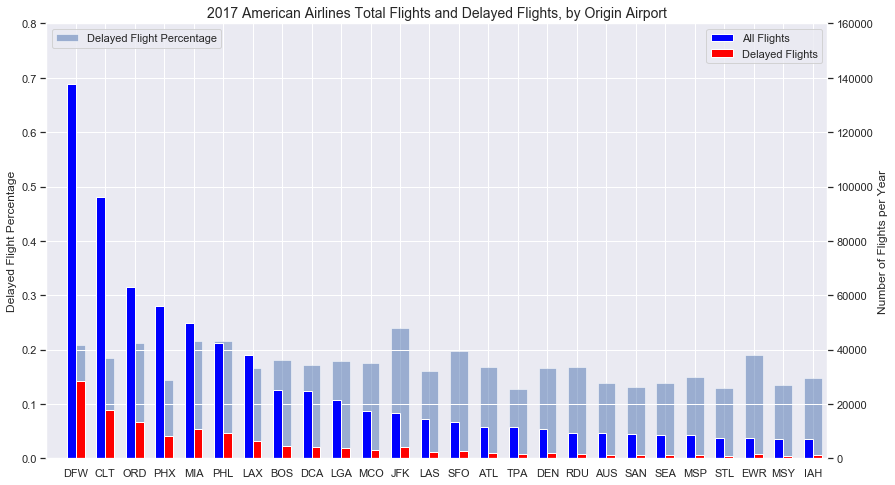

In [1274]:
ax = plt.subplot(111)
ax.bar(American_byOrigin.index, delay_ratioAA, width=0.6, align='center', alpha=0.5)
plt.legend(['Delayed Flight Percentage'], loc='upper left')
plt.ylabel('Delayed Flight Percentage')
plt.ylim(0,0.8)

ax2 = ax.twinx()
ax2.bar(American_byOrigin.index, American_byOrigin, width=-0.3, align='edge', color='blue')
ax2.bar(American_byOrigin_del.index, American_byOrigin_del, width=0.3, align='edge', color='red')
plt.legend(['All Flights', 'Delayed Flights'])
plt.xlabel('Origin Airport')
plt.ylabel('Number of Flights per Year')
plt.title('2017 American Airlines Total Flights and Delayed Flights, by Origin Airport', fontsize=14)
plt.xlim(-1,25.5)
plt.ylim(0,160000)
plt.show()

## Looks like JFK and PHL are top of the list by percentage of delayed flights, this may have to do with airport layout and where American Airlines is located...we can confirm this by looking at taxi times for American Airlines vs other airlines. 

In [1244]:
print(f'American taxi out time for JFK: {round(American[American.ORIGIN == "JFK"]["TAXI_OUT"].mean(),2)} min.')
print(f'All airlines taxi out time for JFK: {round(optimized_df[optimized_df.ORIGIN == "JFK"]["TAXI_OUT"].mean(),2)} min.')

American taxi out time for JFK: 27.99 min.
All airlines taxi out time for JFK: 27.91 min.


In [1245]:
print(f'American taxi out time for PHL: {round(American[American.ORIGIN == "PHL"]["TAXI_OUT"].mean(),2)} min.')
print(f'All airlines taxi out time for PHL: {round(optimized_df[optimized_df.ORIGIN == "PHL"]["TAXI_OUT"].mean(),2)} min.')

American taxi out time for PHL: 23.99 min.
All airlines taxi out time for PHL: 22.2 min.


### We see the same trend as for Southwest, taxi out time is not the major contributor to the delay times for American Airlines at JFK and PHL. These airports may be prone to delays.

#  

# United Airlines

In [1212]:
#Next let's take a look at American Airlines
United = optimized_df[optimized_df.OP_CARRIER == 'UA']
United_del = delays_15[delays_15.OP_CARRIER == 'UA']

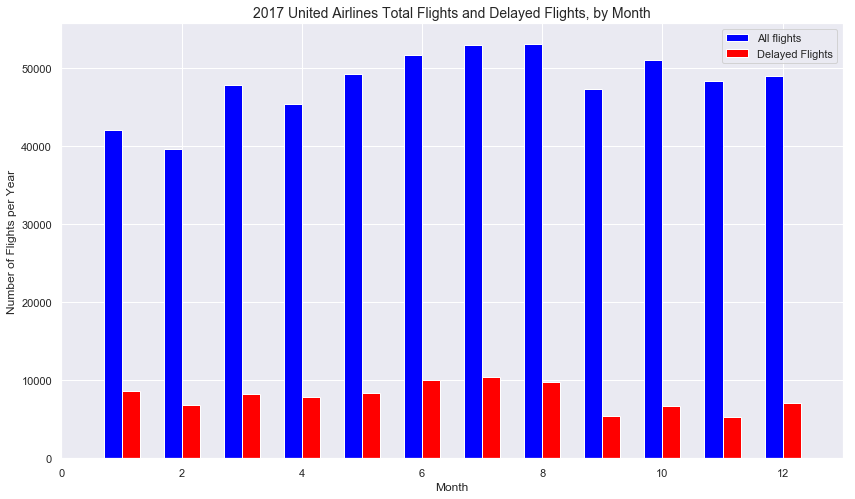

In [1213]:
z = United.groupby('MONTH').size()
y = United_del.groupby('MONTH').size()
ax = plt.subplot(111)
ax.bar(z.index, z, width=-0.3, align='edge', color='blue')
ax.bar(y.index, y, width=0.3, align='edge', color='red')
plt.legend(['All flights', 'Delayed Flights'])
plt.xlabel('Month')
plt.ylabel('Number of Flights per Year')
plt.title('2017 United Airlines Total Flights and Delayed Flights, by Month', fontsize=14)
plt.xlim(0,13)
plt.show()

In [1214]:
United_byOrigin = United.groupby('ORIGIN').size().sort_values(ascending=False)[0:60]
United_byOrigin_del = United_del.groupby('ORIGIN').size().sort_values(ascending=False)[0:60]

In [1215]:
testUA = United.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
testUA_del = United_del.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
ratioUA = testUA_del / testUA 
ratioUA = ratioUA.dropna(axis=0)
delay_ratioUA = ratioUA.get(United_byOrigin.index)

In [1275]:
####use the same index for all data
United_byOrigin_del = United_byOrigin_del.get(United_byOrigin.index)

In [1241]:
delay_ratioUA.sort_values(ascending=False)[0:20]

ORIGIN
PBI    0.263673
EWR    0.231172
ATL    0.230904
BNA    0.219697
SFO    0.206219
BOS    0.204175
EUG    0.198057
SJU    0.197797
MIA    0.192012
ORD    0.174702
RSW    0.173635
RDU    0.164016
FLL    0.161536
MCO    0.161249
LGA    0.160281
LAS    0.159151
IAH    0.158370
MSY    0.158138
DTW    0.156267
IAD    0.153876
dtype: float64

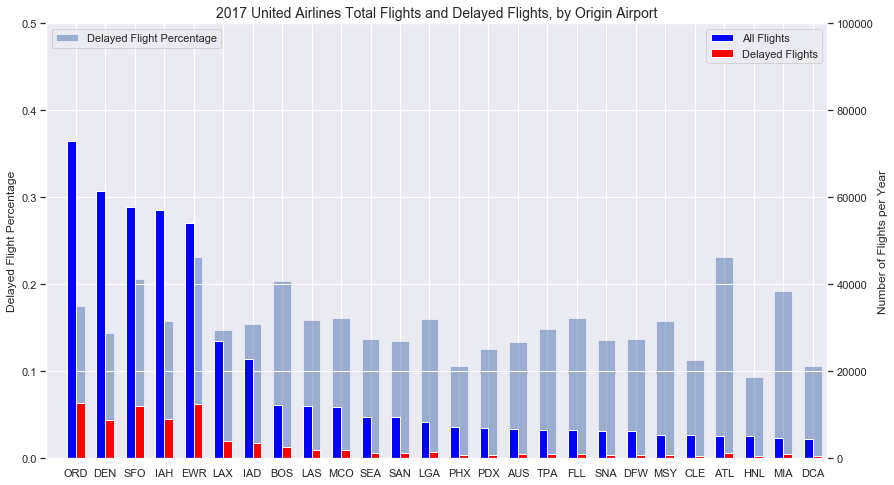

In [1276]:
ax = plt.subplot(111)
ax.bar(United_byOrigin.index, delay_ratioUA, width=0.6, align='center', alpha=0.5)
plt.legend(['Delayed Flight Percentage'], loc='upper left')
plt.ylabel('Delayed Flight Percentage')
plt.ylim(0,0.5)

ax2 = ax.twinx()
ax2.bar(United_byOrigin.index, United_byOrigin, width=-0.3, align='edge', color='blue')
ax2.bar(United_byOrigin_del.index, United_byOrigin_del, width=0.3, align='edge', color='red')
plt.legend(['All Flights', 'Delayed Flights'])
plt.xlabel('Origin Airport')
plt.ylabel('Number of Flights per Year')
plt.title('2017 United Airlines Total Flights and Delayed Flights, by Origin Airport', fontsize=14)
plt.xlim(-1,25.5)
plt.ylim(0,100000)
plt.show()

## Looks like ATL, SFO and EWR are top of the list by percentage of delayed flights, this may have to do with airport layout and where United Airlines is located...we can confirm this by looking at taxi times for United Airlines vs other airlines. 

In [1218]:
print(f'United taxi out time for SFO: {round(United[United.ORIGIN == "SFO"]["TAXI_OUT"].mean(),2)} min.')
print(f'All airlines taxi out time for SFO: {round(optimized_df[optimized_df.ORIGIN == "SFO"]["TAXI_OUT"].mean(),2)} min.')

United taxi out time for SFO: 22.25 min.
All airlines taxi out time for SFO: 21.47 min.


In [1220]:
print(f'United taxi out time for EWR: {round(United[United.ORIGIN == "EWR"]["TAXI_OUT"].mean(),2)} min.')
print(f'All airlines taxi out time for EWR: {round(optimized_df[optimized_df.ORIGIN == "EWR"]["TAXI_OUT"].mean(),2)} min.')

United taxi out time for EWR: 23.43 min.
All airlines taxi out time for EWR: 22.92 min.


### We see the same trend as for Southwest and American, taxi out time is not the major contributor to the delay times for United Airlines at SFO and EWR. However, same airports keep standing out as contributors to delay times.

In [1230]:
(American.YEAR.count() + United.YEAR.count() + SouthWest.YEAR.count()) / optimized_df.YEAR.count()

0.4961849012709229

In [1231]:
(American_del.YEAR.count() + United_del.YEAR.count() + SouthWest_del.YEAR.count()) / delays_15.YEAR.count()

0.506173797384172

# EDA

# Top delayed airports

In [842]:
airports = optimized_df.groupby('ORIGIN').size().sort_values(ascending=False)[0:40]
airports_del = delays_15.groupby('ORIGIN').size().sort_values(ascending=False)[0:40]

In [858]:
#secondary axis
test = optimized_df.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()
test_del = delays_15.groupby('ORIGIN').size().sort_values(ascending=False).sort_index()

In [919]:
#secondary axis
ratio = test_del / test 
delay_ratio = ratio.get(airports.index)

In [1277]:
####use the same index for all data
airports_del = airports_del.get(airports.index)

In [1247]:
delay_ratio.sort_values(ascending=False)[0:20]

ORIGIN
EWR    0.250590
SFO    0.244134
JFK    0.240389
FLL    0.225990
DAL    0.221325
LAX    0.216559
LGA    0.213504
BOS    0.212972
HOU    0.210784
MIA    0.205681
OAK    0.203261
PHL    0.202145
DFW    0.201238
ORD    0.200680
LAS    0.195448
MCO    0.187614
MDW    0.187013
CLT    0.183716
DEN    0.179920
MSY    0.177982
dtype: float64

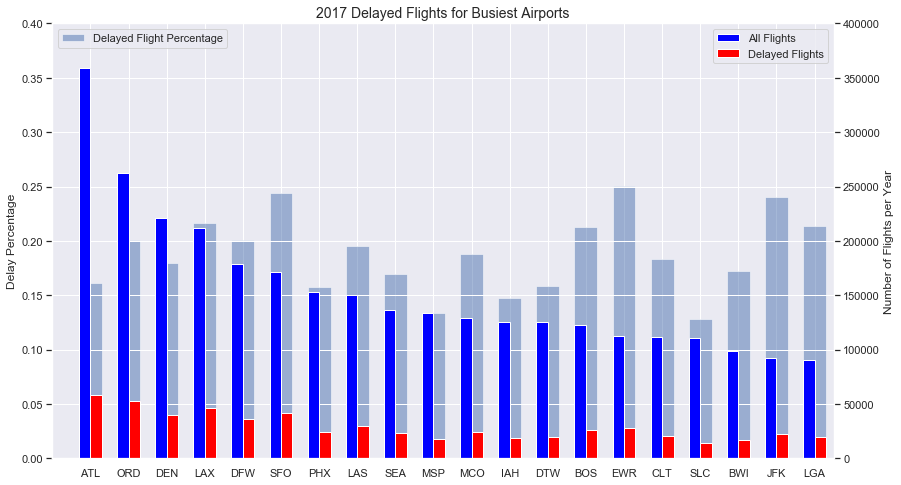

In [1278]:
ax = plt.subplot(111)
ax.bar(delay_ratio.keys(), delay_ratio, width=0.6, align='center', alpha=0.5)
plt.ylim(0,0.4)
plt.legend(['Delayed Flight Percentage'], loc='upper left')
plt.ylabel('Delay Percentage')

ax2 = ax.twinx()
ax2.bar(airports.index, airports, width=-0.3, align='edge', color='blue')
ax2.bar(airports_del.index, airports_del, width=0.3, align='edge', color='red')
plt.legend([ 'All Flights', 'Delayed Flights'])
plt.xlabel('Origin Airport')
plt.ylabel('Number of Flights per Year')
plt.title('2017 Delayed Flights for Busiest Airports', fontsize=14)
plt.xlim(-1,19.5)
plt.ylim(0,400000)

plt.show()

### Above chart shows that although Atlanta is by far the busiest airport as far as flight volume, it does not have the most delays. In fact it has one of the lowest delay rates. The biggest offenders are: EWR, SFO, JFK, BOS, and LGA. We can take a look at those five airports next to see if we can uncover any trends. For example, time of year delays could be linked to weather patterns in the area.

In [1017]:
airports_depdel_time = delays_15.groupby('ORIGIN')['DEP_DELAY'].mean()
airports_arrdel_time = delays_15.groupby('ORIGIN')['ARR_DELAY'].mean()

In [1018]:
mean_depdel_time = airports_depdel_time.get(airports.index)
mean_arrdel_time = airports_arrdel_time.get(airports.index)

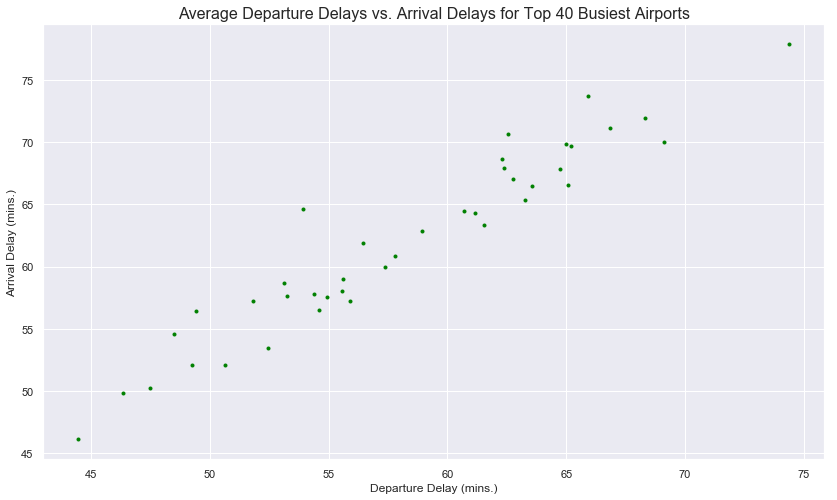

In [1196]:
plt.plot(mean_depdel_time, mean_arrdel_time, marker='.', linestyle='None', color='green')
plt.xlabel('Departure Delay (mins.)')
plt.ylabel('Arrival Delay (mins.)')
plt.title('Average Departure Delays vs. Arrival Delays for Top 40 Busiest Airports', fontsize=16)
plt.show()

#  

# EDA

## What is causing the departure delays at the top five worst performing airports: EWR, SFO, JFK, BOS, and LGA

Arrival delay is what we really care about, but since departure time and arrival time have a linear relationship, we can look at the origin airports for clues.

In [1030]:
top_five = optimized_df[(optimized_df.ORIGIN == 'EWR') | (optimized_df.ORIGIN == 'SFO') |
                        (optimized_df.ORIGIN == 'JFK') | (optimized_df.ORIGIN == 'BOS') | (optimized_df.ORIGIN == 'LGA')]

In [1043]:
top_five_del = delays_15[(delays_15.ORIGIN == 'EWR') | (delays_15.ORIGIN == 'SFO') |
                        (delays_15.ORIGIN == 'JFK') | (delays_15.ORIGIN == 'BOS') | (delays_15.ORIGIN == 'LGA')]

In [1097]:
print(f'Weather delay average: {top_five_del.WEATHER_DELAY.mean()} mins.')
print(f'Carrier delay average: {top_five_del.CARRIER_DELAY.mean()} mins.')
print(f'NAS delay average: {top_five_del.NAS_DELAY.mean()} mins.')
print(f'Security delay average: {top_five_del.SECURITY_DELAY.mean()} mins.')
print(f'Late Aircraft delay average: {top_five_del.LATE_AIRCRAFT_DELAY.mean()} mins.')

Weather delay average: 2.1101489067077637 mins.
Carrier delay average: 19.4080810546875 mins.
NAS delay average: 17.34543800354004 mins.
Security delay average: 0.10083397477865219 mins.
Late Aircraft delay average: 31.24814796447754 mins.


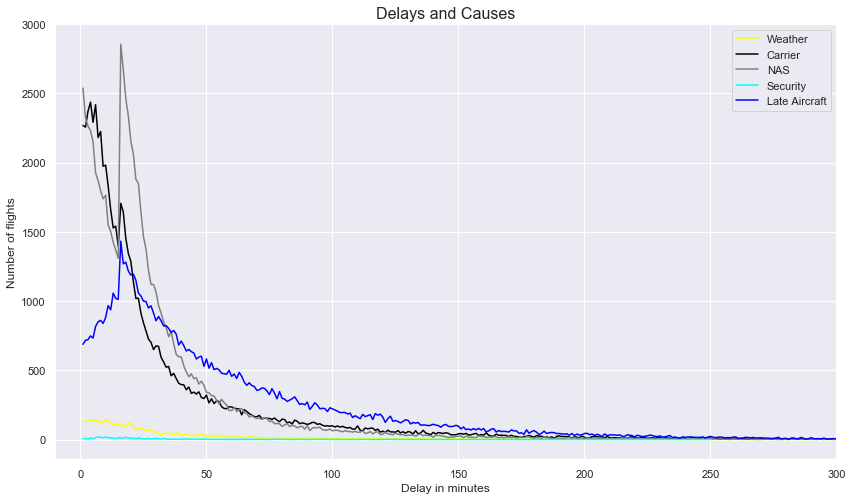

In [1101]:
top_five_del.groupby('WEATHER_DELAY').size()[1:].plot(color='yellow')
top_five_del.groupby('CARRIER_DELAY').size()[1:].plot(color='black')
top_five_del.groupby('NAS_DELAY').size()[1:].plot(color='gray')
top_five_del.groupby('SECURITY_DELAY').size()[1:].plot(color='cyan')
top_five_del.groupby('LATE_AIRCRAFT_DELAY').size()[1:].plot(color='blue')
plt.xlim(-10,300)
plt.xlabel('Delay in minutes')
plt.ylabel('Number of flights')
plt.title('Delays and Causes', fontsize=16)
plt.legend(['Weather', 'Carrier', 'NAS', 'Security', 'Late Aircraft'])

#### It looks like Late Aircraft (previous flight from the same carrier arriving late), NAS (delays due to heavy air traffic, airport operations, but not extreme weather), and Carrier (delay due to an event within the control of the airline) delays make up majority of the delay causes.

### NAS Delay

#### NAS - We can continue to look at patterns for heavy traffic or trends in increassing air traffic patterns areas and look for consitancies. Addionally, although extreme events are not considered here, normal weather patterns that cause air traffic slowdowns are. Looking at weather patterns may be beneficial. FAA has a database breaking down the NAS delays by cause. (FAA OPSNET)

### Carrier Delay 

#### Carrier - carrier performance can be further analyzed by location and see if there are patterns

### Late Aircraft

#### Late Aircraft - This can be handled with arrival delay information. This field highly depends on the other delay causes.

In [1107]:
all_flights = optimized_df.YEAR.count()

In [1132]:
on_time_df = optimized_df[optimized_df.ARR_DELAY <= 15]

In [ ]:
on_time = on_time_df.YEAR.count()

In [1133]:
weather = delays_15[delays_15.WEATHER_DELAY > 0].count()
carrier = delays_15[delays_15.CARRIER_DELAY > 0].count()
NAS = delays_15[delays_15.NAS_DELAY > 0].count()
security = delays_15[delays_15.SECURITY_DELAY > 0].count()
late_aircraft = delays_15[delays_15.LATE_AIRCRAFT_DELAY > 0].count()
on_time = on_time_df.YEAR.count()

In [1134]:
weather_percent = weather.YEAR / all_flights
carrier_percent = carrier.YEAR / all_flights
NAS_percent = NAS.YEAR / all_flights
security_percent = security.YEAR / all_flights
late_aircraft_delay_percent = late_aircraft.YEAR / all_flights
no_delay_percent = on_time / all_flights

In [1144]:
x = [weather_percent, carrier_percent, security_percent, NAS_percent, late_aircraft_delay_percent, no_delay_percent]

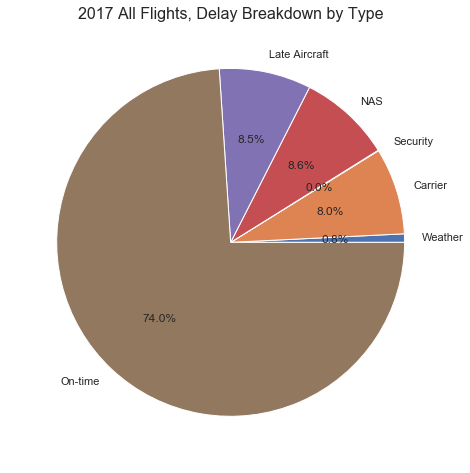

In [1146]:
plt.pie(x, labels=['Weather', 'Carrier', 'Security', 'NAS', 'Late Aircraft', 'On-time'], autopct='%1.1f%%')
plt.title('2017 All Flights, Delay Breakdown by Type', fontsize=16)
plt.show()

### FAA has data available for NAS delays, further broken down by category.
https://aspm.faa.gov/opsnet/sys/Delays.asp

In [1197]:
nas_delay = pd.read_csv('NAS_delay.csv')

In [1198]:
nas_delay.head()

,Year,Facility,Class,All Delays,All Avg. min.,all Total min.,Weather Number of Delays,Weather avg,Weather total,volume number of delays,...,volume total,Equipment number of delays,Equipment avg.,Equipment total,runway number of delays,runway avg.,runway total,Other number of delays,other avg.,other total
0,2004.0,ABQ,Combined TRACON & Tower with Radar,82.0,83.0,6833.0,19.0,69.0,1320.0,1.0,...,47.0,22.0,131.0,2880.0,3.0,47.0,140.0,37.0,66.0,2446.0
1,2004.0,ANC,Towers with Radar,162.0,28.0,4610.0,47.0,27.0,1256.0,47.0,...,1593.0,33.0,23.0,765.0,19.0,23.0,438.0,16.0,35.0,558.0
2,2004.0,ATL,Combined TRACON & Tower with Radar,33604.0,58.0,1955960.0,30435.0,61.0,1867793.0,2821.0,...,77037.0,42.0,52.0,2167.0,102.0,26.0,2640.0,204.0,31.0,6323.0
3,2004.0,ATL,Towers with Radar,6457.0,64.0,410196.0,6047.0,65.0,394153.0,347.0,...,11514.0,2.0,34.0,67.0,18.0,77.0,1381.0,43.0,72.0,3081.0
4,2004.0,AUS,Combined TRACON & Tower with Radar,25.0,66.0,1653.0,7.0,62.0,432.0,1.0,...,18.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,71.0,1203.0


In [1301]:
NAS_2017 = nas_delay[(nas_delay.Year == 2017)]

In [1302]:
NAS_2017.head()

,Year,Facility,Class,All Delays,All Avg. min.,all Total min.,Weather Number of Delays,Weather avg,Weather total,volume number of delays,...,volume total,Equipment number of delays,Equipment avg.,Equipment total,runway number of delays,runway avg.,runway total,Other number of delays,other avg.,other total
1028,2017.0,ABQ,Combined TRACON & Tower with Radar,28.0,24.0,671.0,0.0,0.0,0.0,28.0,...,671.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1029,2017.0,ANC,Towers with Radar,174.0,22.0,3821.0,70.0,22.0,1552.0,31.0,...,691.0,0.0,0.0,0.0,18.0,19.0,349.0,55.0,22.0,1229.0
1030,2017.0,ATL,Towers with Radar,6137.0,48.0,291864.0,4532.0,54.0,246884.0,1141.0,...,26787.0,6.0,18.0,109.0,153.0,20.0,3083.0,305.0,49.0,15001.0
1031,2017.0,AUS,Combined TRACON & Tower with Radar,8.0,32.0,257.0,1.0,21.0,21.0,5.0,...,154.0,0.0,0.0,0.0,2.0,41.0,82.0,0.0,0.0,0.0
1032,2017.0,BDL,Towers with Radar,1.0,23.0,23.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,23.0


In [1327]:
total_time = NAS_2017.groupby('Facility')['all Total min.'].sum().sort_index()
volume_time = NAS_2017.groupby('Facility')['volume total'].sum().sort_index()
equipment_time = NAS_2017.groupby('Facility')['Equipment total'].sum().sort_index()
runway_time = NAS_2017.groupby('Facility')['runway total'].sum().sort_index()
other_time = NAS_2017.groupby('Facility')['other total'].sum().sort_index()
weather_time = NAS_2017.groupby('Facility')['Weather total'].sum().sort_index()

In [1337]:
percent_volume = volume_time / total_time
percent_equipment = equipment_time / total_time
percent_runway = runway_time / total_time
percent_other = other_time / total_time
percent_weather = weather_time / total_time

In [1342]:
total_time = total_time.sort_values(ascending=False)

In [1348]:
percent_volume = percent_volume.get(total_time.index)[0:100]
percent_equipment = percent_equipment.get(total_time.index)[0:100]
percent_runway = percent_runway.get(total_time.index)[0:100]
percent_other = percent_other.get(total_time.index)[0:100]
percent_weather = percent_weather.get(total_time.index)[0:100]

In [1356]:
all_weather = weather_time.sum() / total_time.sum()
all_equipment = equipment_time.sum() / total_time.sum()
all_runway = runway_time.sum() / total_time.sum()
all_volume = volume_time.sum() / total_time.sum()
all_other = other_time.sum() / total_time.sum()

In [1358]:
x = [all_weather, all_equipment, all_runway, all_volume, all_other]

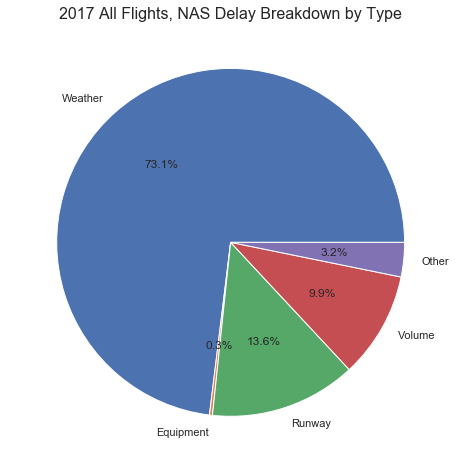

In [1359]:
plt.pie(x, labels=['Weather', 'Equipment', 'Runway', 'Volume', 'Other'], autopct='%1.1f%%')
plt.title('2017 All Flights, NAS Delay Breakdown by Type', fontsize=16)
plt.show()

# OTHER EDA....IN PROGRESS

## Most popular route in United States (by number of flights) SFO to LAX

In [208]:
#Let's find the most popular route in the US (the most flights per year between any two cities.)
optimized_df.groupby(['ORIGIN','DEST']).size().sort_values(ascending=False).head()

ORIGIN  DEST
SFO     LAX     15243
LAX     SFO     15032
        JFK     12607
JFK     LAX     12604
LAS     LAX     10970
dtype: int64

In [28]:
#Create a dataframe with the most popular route 
#This has all the flights, delayed and normal
#We need to split this into two dataframes: flights that are delayed and flights that are not
popular_route = optimized_df[(optimized_df.ORIGIN == 'SFO') & (optimized_df.DEST == 'LAX')]

In [164]:
popular_route.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,...,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DEP_TIME_SCALE,ARR_TIME_SCALE
10282,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,82.0,55.0,337.0,NaN,NaN,NaN,NaN,NaN,680.000000,816.666667
10284,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,106.0,58.0,337.0,NaN,NaN,NaN,NaN,NaN,783.333333,960.000000
10286,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,109.0,57.0,337.0,NaN,NaN,NaN,NaN,NaN,870.000000,1051.666667
10288,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,87.0,57.0,337.0,NaN,NaN,NaN,NaN,NaN,978.333333,1123.333333
10290,2017,3,1,3,2017-03-01,OO,SFO,"San Francisco, CA",CA,LAX,...,86.0,61.0,337.0,NaN,NaN,NaN,NaN,NaN,1078.333333,1221.666667


In [86]:
popular_route['DEP_TIME_SCALE'] = popular_route.DEP_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [91]:
popular_route['ARR_TIME_SCALE'] = popular_route.ARR_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [93]:
#We need to split the popular_route dataframe into two: flights that are delayed and flights that are not
#Create a dataframe with only delayed flights of greater than 15 minutes for the most popular route
popular_route_del = popular_route[(popular_route.ARR_DELAY > 15) & (popular_route.ARR_DELAY < 180)]
#Create a dataframe with non-delayed flights
popular_route_norm = popular_route[popular_route.ARR_DELAY <= 15]

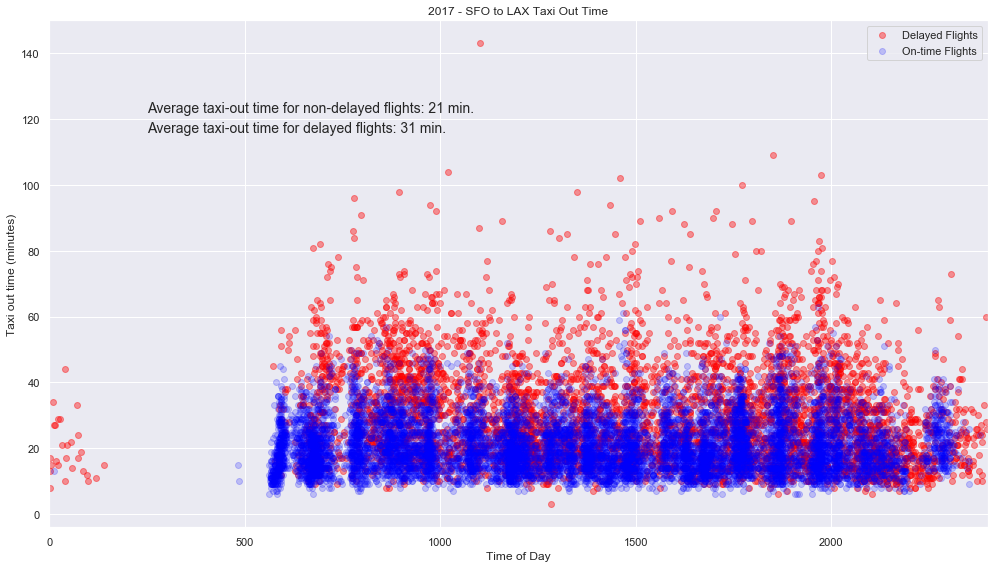

In [154]:
#The taxi out time at the destination for delayed and normal flights
x_normal = popular_route_norm.DEP_TIME_SCALE
y_normal = popular_route_norm.TAXI_OUT
x_delayed = popular_route_del.DEP_TIME_SCALE
y_delayed = popular_route_del.TAXI_OUT

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Taxi out time (minutes)')
ax.set_title('2017 - SFO to LAX Taxi Out Time')
plt.text(250, 122, f"Average taxi-out time for non-delayed flights: {round(popular_route_norm.TAXI_OUT.mean())} min.", fontsize=14)
plt.text(250, 116, f"Average taxi-out time for delayed flights: {round(popular_route_del.TAXI_OUT.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

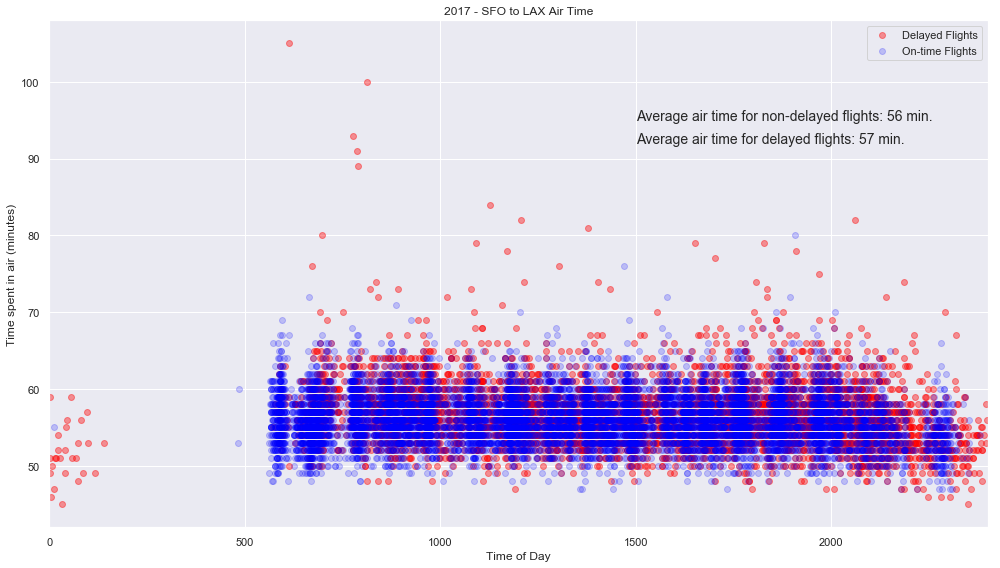

In [158]:
#Flight time for delayed and normal flights
x_normal = popular_route_norm.DEP_TIME_SCALE
y_normal = popular_route_norm.AIR_TIME
x_delayed = popular_route_del.DEP_TIME_SCALE
y_delayed = popular_route_del.AIR_TIME

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Time spent in air (minutes)')
ax.set_title('2017 - SFO to LAX Air Time')
plt.text(1500, 95, f"Average air time for non-delayed flights: {round(popular_route_norm.AIR_TIME.mean())} min.", fontsize=14)
plt.text(1500, 92, f"Average air time for delayed flights: {round(popular_route_del.AIR_TIME.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

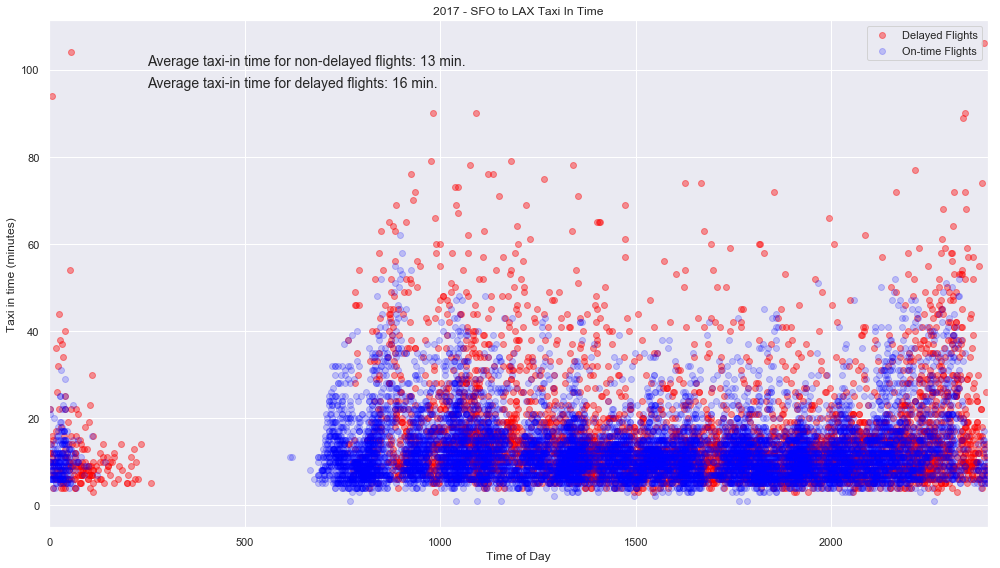

In [159]:
#And the taxi in time at the destination for delayed and normal flights
x_normal = popular_route_norm.ARR_TIME_SCALE
y_normal = popular_route_norm.TAXI_IN
x_delayed = popular_route_del.ARR_TIME_SCALE
y_delayed = popular_route_del.TAXI_IN

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Taxi in time (minutes)')
ax.set_title('2017 - SFO to LAX Taxi In Time')
plt.text(250, 101, f"Average taxi-in time for non-delayed flights: {round(popular_route_norm.TAXI_IN.mean())} min.", fontsize=14)
plt.text(250, 96, f"Average taxi-in time for delayed flights: {round(popular_route_del.TAXI_IN.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

In [95]:
#Computing summaries
#Total flights between the most populare cities
total_flights = optimized_df.groupby(['ORIGIN','DEST']).size().sort_values(ascending=False)[0]
delayed_flights = popular_route_del.YEAR.count()
not_delayed_flights = popular_route_norm.YEAR.count()
print(f"Total flights from SFO to LAX in 2017: {total_flights}")
print(f"Flights that are arriving late by more than 15 minutes: {delayed_flights} \
({round(delayed_flights / total_flights * 100, 1)}%)")
print(f"Flights that are arriving early or on time: {not_delayed_flights} \
({round(not_delayed_flights / total_flights * 100, 1)}%)")
print("*Remainder of flights were delayed longer than 3 hours")

Total flights from SFO to LAX in 2017: 15243
Flights that are arriving late by more than 15 minutes: 4747 (31.1%)
Flights that are arriving early or on time: 10299 (67.6%)
*Remainder of flights were delayed longer than 3 hours


Text(0.5, 1.0, 'SFO to LAX Arrival Delays of 15min+')

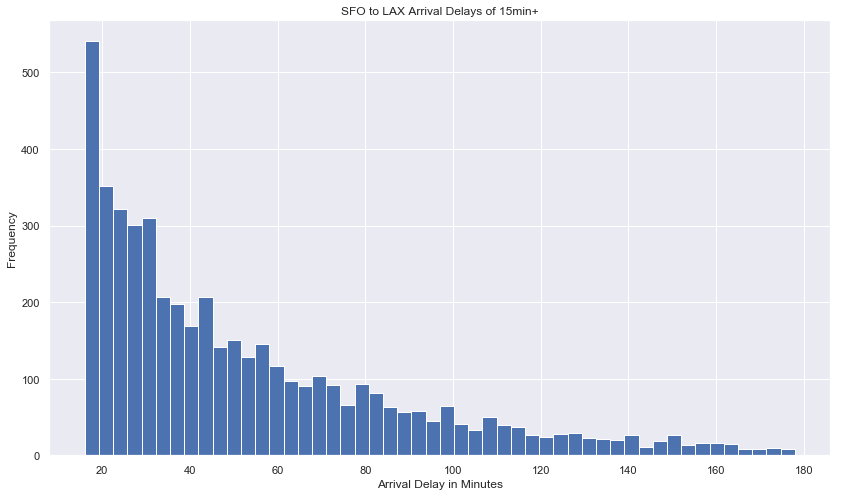

In [506]:
popular_route_del.ARR_DELAY.hist(bins=50)
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('Frequency')
plt.title('SFO to LAX Arrival Delays of 15min+')

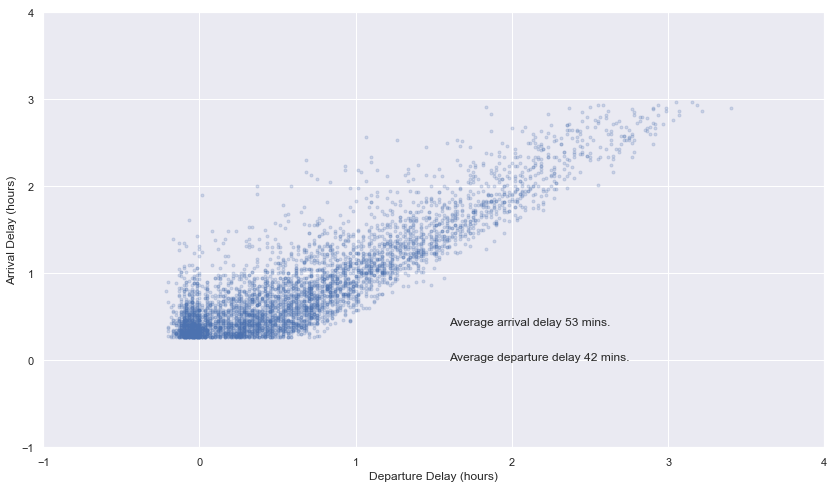

In [507]:
plt.plot(popular_route_del.DEP_DELAY / 60, popular_route_del.ARR_DELAY / 60, marker='.', linestyle='None', alpha = 0.2)
plt.xlim([-1, 4])
plt.ylim([-1, 4])
plt.xlabel('Departure Delay (hours)')
plt.ylabel('Arrival Delay (hours)')
plt.text(1.6, 0, f"Average departure delay {round((popular_route_del.DEP_DELAY).mean())} mins.")
plt.text(1.6, 0.4, f"Average arrival delay {round((popular_route_del.ARR_DELAY).mean())} mins.")
plt.show()

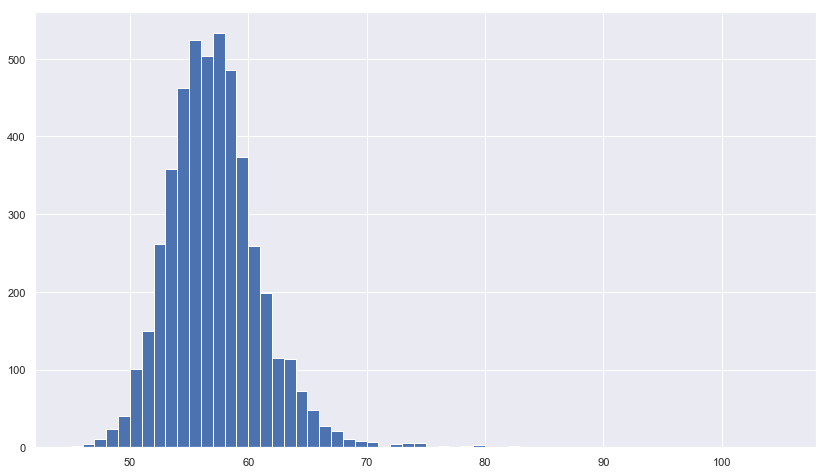

In [792]:
popular_route_del.AIR_TIME.hist(bins=60)

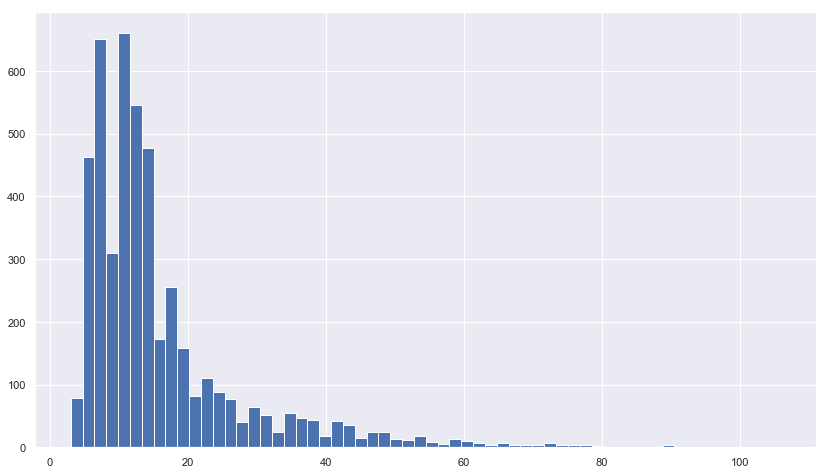

In [510]:
popular_route_del.TAXI_IN.hist(bins=60)

Text(0, 0.5, 'Arrival Delay (minutes)')

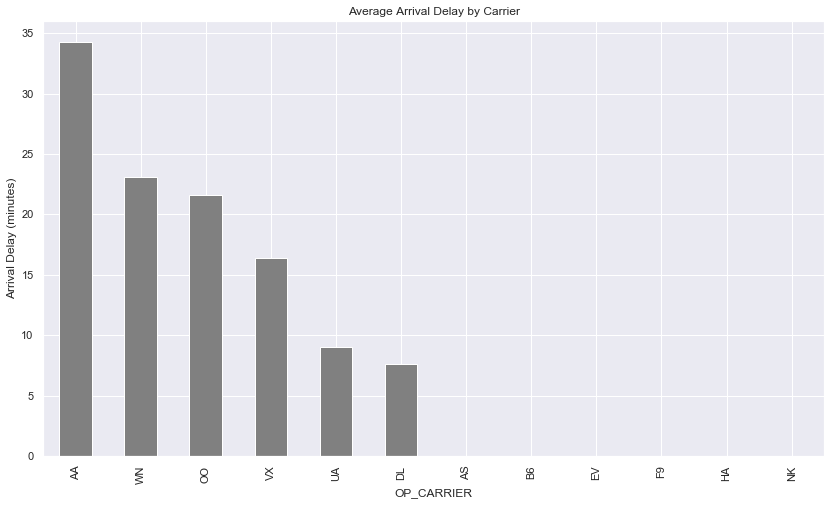

In [598]:
popular_route.groupby('OP_CARRIER')['ARR_DELAY'].mean().sort_values(ascending=False).plot(kind='bar', color='gray')
plt.title('Average Arrival Delay by Carrier')
plt.ylabel('Arrival Delay (minutes)')

## Second most popular route in United States (by number of flights) LAX to JFK

#### This example is a longer route

In [96]:
#Create a dataframe with the most popular route 
#This has all the flights, delayed and normal
#We need to split this into two dataframes: flights that are delayed and flights that are not
popular_route2 = optimized_df[(optimized_df.ORIGIN == 'LAX') & (optimized_df.DEST == 'JFK')]

Text(0, 0.5, 'Departure Delay (minutes)')

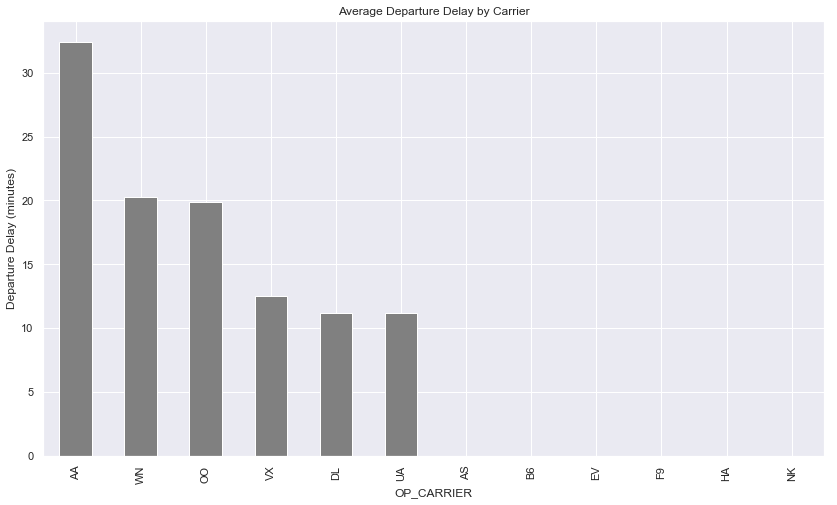

In [599]:
popular_route.groupby('OP_CARRIER')['DEP_DELAY'].mean().sort_values(ascending=False).plot(kind='bar', color='gray')
plt.title('Average Departure Delay by Carrier')
plt.ylabel('Departure Delay (minutes)')

In [97]:
popular_route2['DEP_TIME_SCALE'] = popular_route2.DEP_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
popular_route2['ARR_TIME_SCALE'] = popular_route2.ARR_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
#We need to split the popular_route dataframe into two: flights that are delayed and flights that are not
#Create a dataframe with only delayed flights of greater than 15 minutes for the most popular route
popular_route2_del = popular_route2[(popular_route2.ARR_DELAY > 15) & (popular_route2.ARR_DELAY < 240)]
#Create a dataframe with non-delayed flights
popular_route2_norm = popular_route2[popular_route2.ARR_DELAY <= 15]

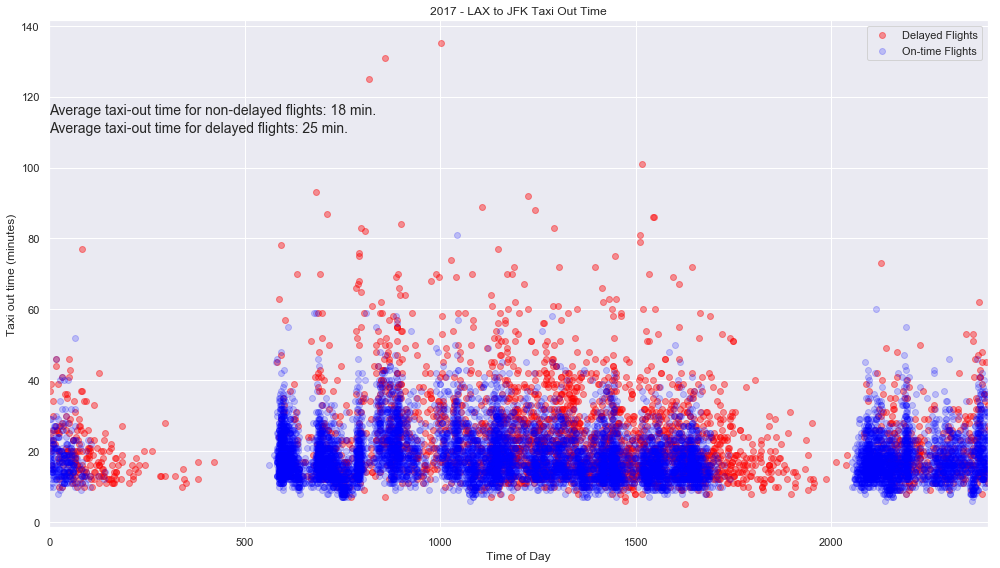

In [160]:
#The taxi out time at the destination for delayed and normal flights
x_normal = popular_route2_norm.DEP_TIME_SCALE
y_normal = popular_route2_norm.TAXI_OUT
x_delayed = popular_route2_del.DEP_TIME_SCALE
y_delayed = popular_route2_del.TAXI_OUT

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Taxi out time (minutes)')
ax.set_title('2017 - LAX to JFK Taxi Out Time')
plt.text(0, 115, f"Average taxi-out time for non-delayed flights: {round(popular_route2_norm.TAXI_OUT.mean())} min.", fontsize=14)
plt.text(0, 110, f"Average taxi-out time for delayed flights: {round(popular_route2_del.TAXI_OUT.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

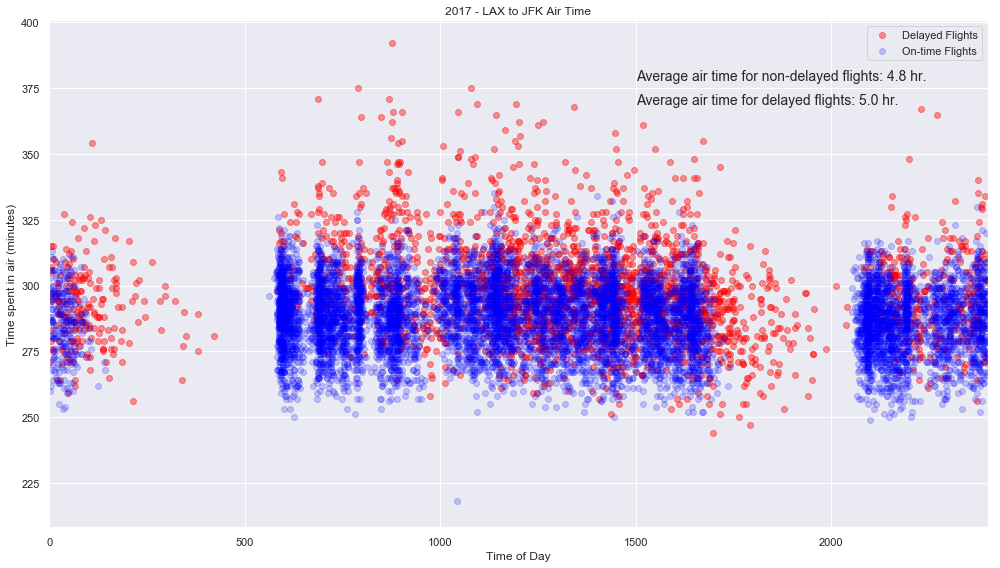

In [161]:
#Air time from LAX to JFK
x_normal = popular_route2_norm.DEP_TIME_SCALE
y_normal = popular_route2_norm.AIR_TIME
x_delayed = popular_route2_del.DEP_TIME_SCALE
y_delayed = popular_route2_del.AIR_TIME

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Time spent in air (minutes)')
ax.set_title('2017 - LAX to JFK Air Time')
plt.text(1500, 378, f"Average air time for non-delayed flights: {round(popular_route2_norm.AIR_TIME.mean()/60,1)} hr.", fontsize=14)
plt.text(1500, 369, f"Average air time for delayed flights: {round(popular_route2_del.AIR_TIME.mean()/60,1)} hr.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

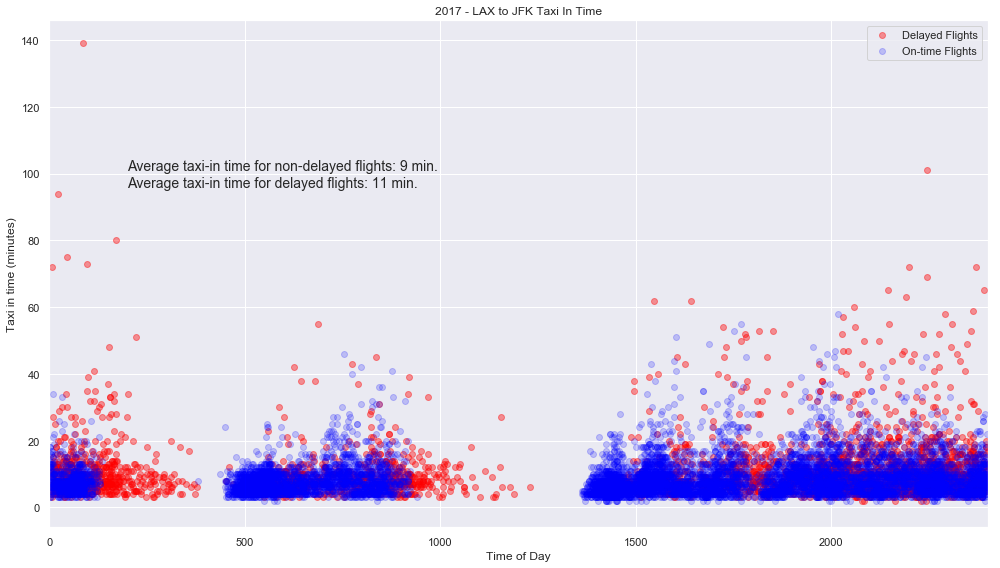

In [162]:
#And the taxi in time at the destination for delayed and normal flights
x_normal = popular_route2_norm.ARR_TIME_SCALE
y_normal = popular_route2_norm.TAXI_IN
x_delayed = popular_route2_del.ARR_TIME_SCALE
y_delayed = popular_route2_del.TAXI_IN

fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x_delayed, y_delayed, alpha=0.4, color='red')
ax.scatter(x_normal, y_normal, alpha=0.2, color='blue')

ax.set_xlabel('Time of Day')
ax.set_ylabel('Taxi in time (minutes)')
ax.set_title('2017 - LAX to JFK Taxi In Time')
plt.text(200, 101, f"Average taxi-in time for non-delayed flights: {round(popular_route2_norm.TAXI_IN.mean())} min.", fontsize=14)
plt.text(200, 96, f"Average taxi-in time for delayed flights: {round(popular_route2_del.TAXI_IN.mean())} min.", fontsize=14)
plt.xlim(0, 2400)
plt.legend(['Delayed Flights', 'On-time Flights'])
fig.tight_layout()

#  

# EDA

#  Busy times in the airport will produce more delays (arrivals and departures)

Ho: Delay times do not increase during busy airport times Ha: Delay times increase as number of departures and arrivals increases

In [339]:
#Let's look at the busiest airport by flights per year: ATL. We'll need two dataframes: 
#Departing flights and arriving flights
departing = optimized_df[(optimized_df.ORIGIN == 'ATL')]
arriving = optimized_df[(optimized_df.DEST == 'ATL')]

In [340]:
#scale the times of departure and arrival
departing['DEP_TIME_SCALE'] = departing.DEP_TIME.apply(time_to_float)
arriving['ARR_TIME_SCALE'] = arriving.ARR_TIME.apply(time_to_float)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [374]:
departing_del = departing[departing.ARR_DELAY > 15]
arriving_del = arriving[arriving.ARR_DELAY > 15]

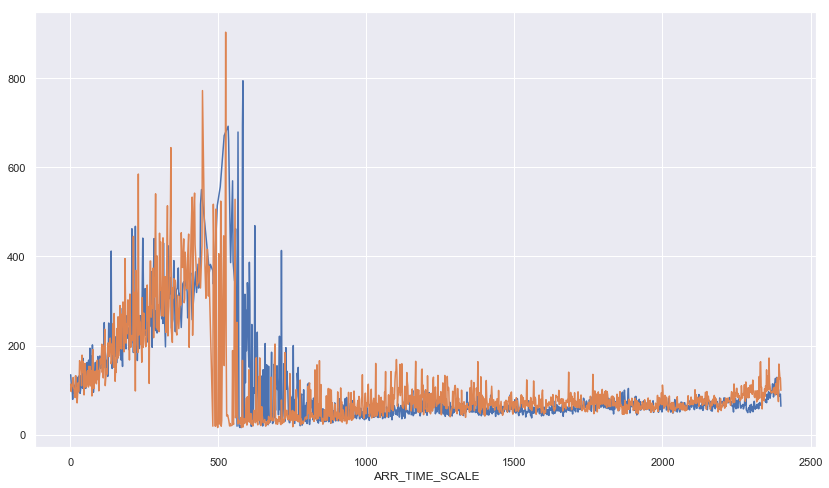

In [436]:
departing_del.groupby("DEP_TIME_SCALE")['ARR_DELAY'].mean().plot()
arriving_del.groupby("ARR_TIME_SCALE")['ARR_DELAY'].mean().plot()

Text(0.5, 1.0, '2017 Atlanta Airport Traffic')

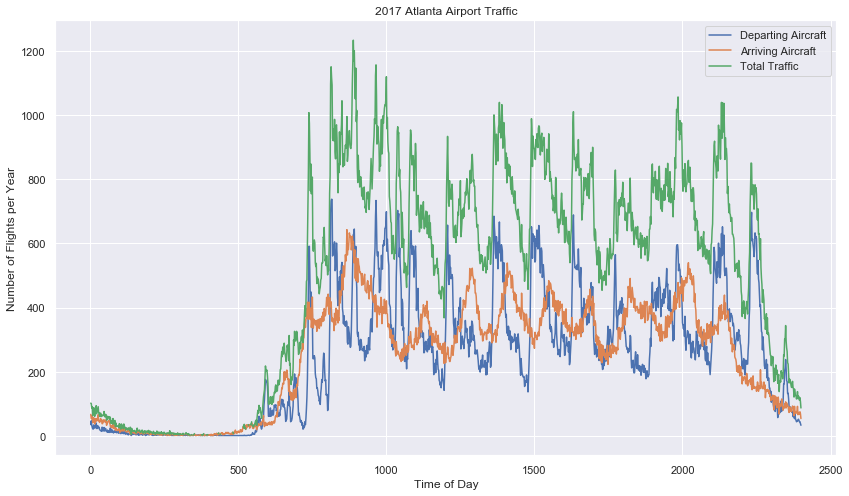

In [400]:
departing.groupby("DEP_TIME_SCALE").size().plot()
arriving.groupby("ARR_TIME_SCALE").size().plot()
(departing.groupby("DEP_TIME_SCALE").size() + arriving.groupby("ARR_TIME_SCALE").size()).plot()
plt.xlabel('Time of Day')
plt.ylabel('Number of Flights per Year')
plt.legend(['Departing Aircraft', 'Arriving Aircraft', 'Total Traffic'])
plt.title('2017 Atlanta Airport Traffic')

Text(0, 0.5, 'Number of Flights per Year')

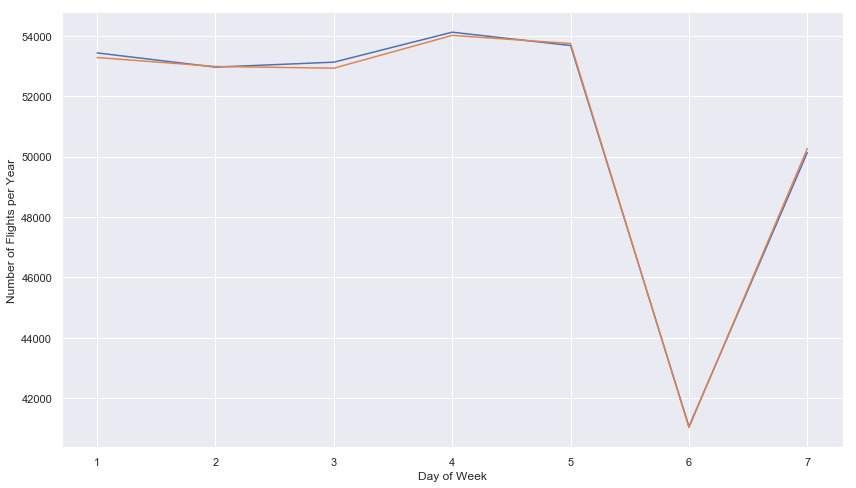

In [392]:
departing.groupby('DAY_OF_WEEK').size().plot()
arriving.groupby('DAY_OF_WEEK').size().plot()

plt.xlabel('Day of Week')
plt.ylabel('Number of Flights per Year')

Text(0, 0.5, 'Number of Flights per Year')

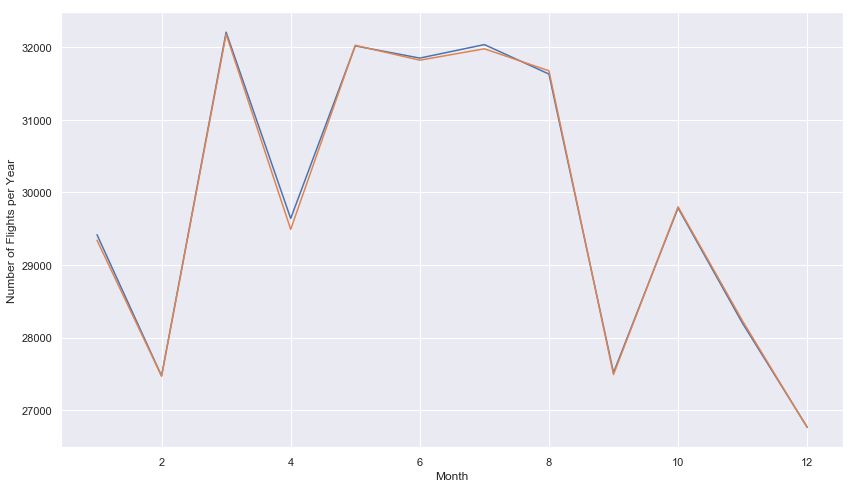

In [393]:
departing.groupby('MONTH').size().plot()
arriving.groupby('MONTH').size().plot()

plt.xlabel('Month')
plt.ylabel('Number of Flights per Year')

It looks like March is the busiest month and Thursday is the busiest day. We can look into more detail for that combindation.

In [406]:
busy_depart = departing[(departing.MONTH == 3) & (departing.DAY_OF_WEEK == 4)]
busy_depart_del = departing_del[(departing_del.MONTH == 3) & (departing_del.DAY_OF_WEEK == 4)]

busy_arrive = arriving[(arriving.MONTH == 3) & (arriving.DAY_OF_WEEK == 4)]
busy_arrive_del = arriving_del[(arriving_del.MONTH == 3) & (arriving_del.DAY_OF_WEEK == 4)]

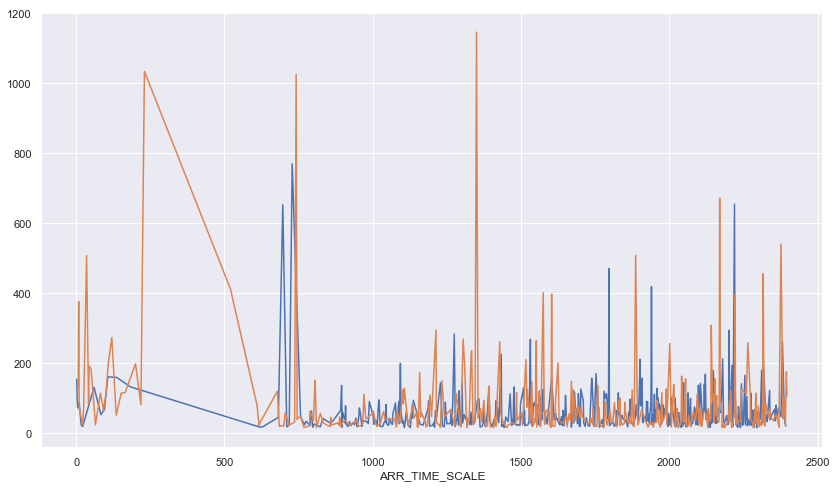

In [433]:
busy_depart_del.groupby("DEP_TIME_SCALE")['ARR_DELAY'].max().plot()
busy_arrive_del.groupby("ARR_TIME_SCALE")['ARR_DELAY'].max().plot()


Text(0, 0.5, 'Number of Flights on the Runway')

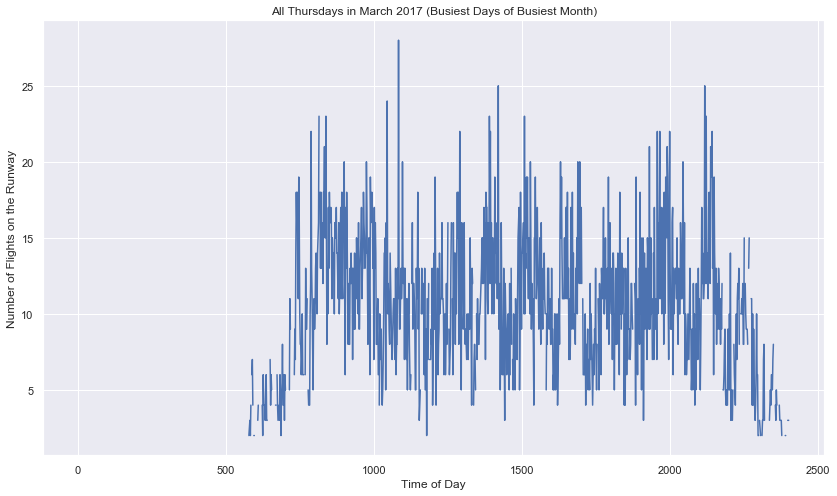

In [435]:
#busy_depart.groupby("DEP_TIME_SCALE").size().plot()
#busy_arrive.groupby("ARR_TIME_SCALE").size().plot()

(busy_depart.groupby("DEP_TIME_SCALE").size() + busy_arrive.groupby("ARR_TIME_SCALE").size()).plot()
plt.title('All Thursdays in March 2017 (Busiest Days of Busiest Month)')
plt.xlabel('Time of Day')
plt.ylabel('Number of Flights on the Runway')

# EDA 

## General questions about the airline data

In [438]:
#Which day of the week is worst for late flights SFO to LAX (most popular route by number of flights)
popular_route.groupby("DAY_OF_WEEK")['ARR_DELAY'].mean().sort_values(ascending=False)

DAY_OF_WEEK
5    23.044930
7    21.261126
4    20.176142
1    18.590115
3    12.199914
2     8.232688
6     3.984426
Name: ARR_DELAY, dtype: float32

In [455]:
#Which day of the week is worst for late flights LAX to JFK
popular_route2.groupby("DAY_OF_WEEK")['ARR_DELAY'].mean().sort_values(ascending=False)

DAY_OF_WEEK
5    13.010983
4     7.075353
7     6.900896
1     5.973503
6     5.100828
2     4.979659
3    -3.330993
Name: ARR_DELAY, dtype: float32

In [439]:
#Which day of the week is worst for late flights 2017
optimized_df.groupby("DAY_OF_WEEK")['ARR_DELAY'].mean().sort_values(ascending=False)

DAY_OF_WEEK
5    7.025164
1    6.165920
4    5.589318
7    3.575832
3    3.186620
2    2.304735
6    1.892079
Name: ARR_DELAY, dtype: float32

Text(0.5, 1.0, 'Average Flight Delay by Day of Week')

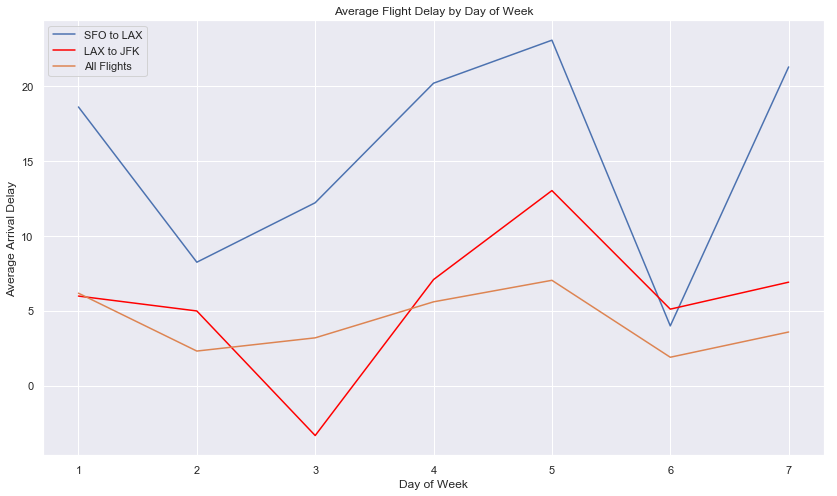

In [457]:
popular_route.groupby("DAY_OF_WEEK")['ARR_DELAY'].mean().plot()
popular_route2.groupby("DAY_OF_WEEK")['ARR_DELAY'].mean().plot(color='red')
optimized_df.groupby("DAY_OF_WEEK")['ARR_DELAY'].mean().plot()
plt.xlabel('Day of Week')
plt.ylabel('Average Arrival Delay')
plt.legend(['SFO to LAX', 'LAX to JFK', 'All Flights'])
plt.title('Average Flight Delay by Day of Week')

Average arrival delays seems to be higher for shorter flights.

In [489]:
#Which month of the year is worst for late flights SFO to LAX
popular_route.groupby("MONTH")['ARR_DELAY'].mean().sort_values(ascending=False)

MONTH
5     32.686577
2     29.408236
1     27.444445
4     24.590086
3     21.338530
8     17.400730
10    10.787538
6     10.705138
9      7.500000
7      7.070796
11     4.052674
12    -1.862713
Name: ARR_DELAY, dtype: float32

In [456]:
#Which month of the year is worst for late flights LAX to JFK
popular_route2.groupby("MONTH")['ARR_DELAY'].mean().sort_values(ascending=False)

MONTH
5     27.251177
7     14.174312
4     12.487452
6     11.133333
3      9.865221
10     5.494128
8      3.423729
12     0.359848
1      0.187259
2     -1.635179
9     -3.923598
11   -11.315187
Name: ARR_DELAY, dtype: float32

In [454]:
#Which month of the year is worst for late flights
optimized_df.groupby("MONTH")['ARR_DELAY'].mean().sort_values(ascending=False)

MONTH
6     9.132848
7     8.295148
4     7.322608
1     6.954484
8     6.692595
5     6.029890
3     4.306398
12    3.586025
10    1.179531
2     0.687559
9    -0.555612
11   -3.179592
Name: ARR_DELAY, dtype: float32

Text(0.5, 1.0, 'Average Flight Delay by Month')

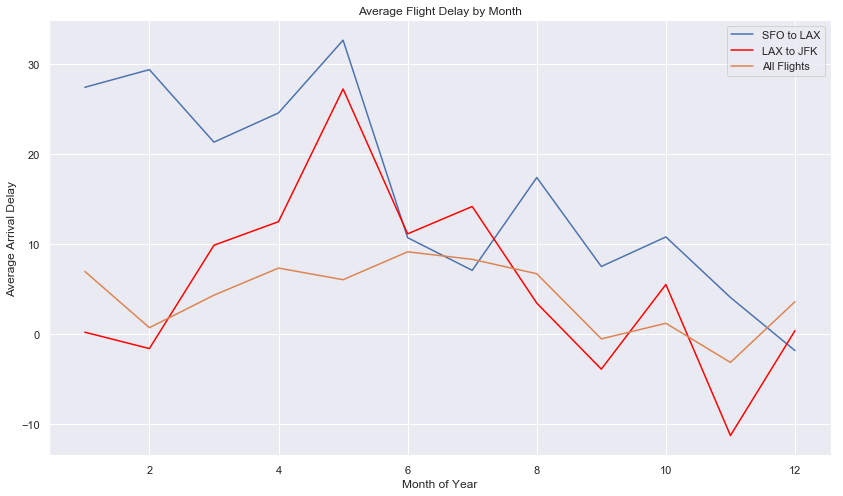

In [458]:
popular_route.groupby("MONTH")['ARR_DELAY'].mean().plot()
popular_route2.groupby("MONTH")['ARR_DELAY'].mean().plot(color='red')
optimized_df.groupby("MONTH")['ARR_DELAY'].mean().plot()
plt.xlabel('Month of Year')
plt.ylabel('Average Arrival Delay')
plt.legend(['SFO to LAX', 'LAX to JFK', 'All Flights'])
plt.title('Average Flight Delay by Month')

In [446]:
sns.barplot(popular_route.groupby("DAY_OF_WEEK"), popular_route.groupby("DAY_OF_WEEK")['ARR_DELAY'].mean())

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

Text(0.5, 1.0, 'SFO to LAX Average Arrival Delay by Airline')

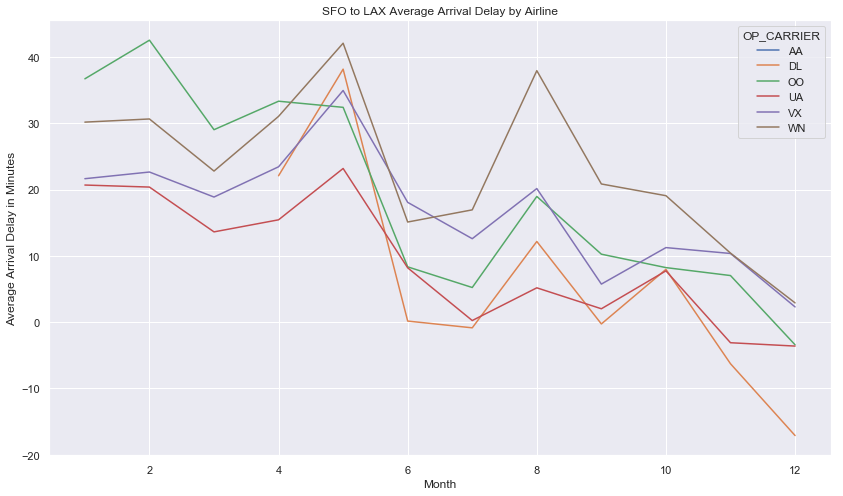

In [502]:
#What is the average arrival delay per month broken down by airline SFO to LAX
popular_route.groupby(["OP_CARRIER", "MONTH"])['ARR_DELAY'].mean().unstack('OP_CARRIER').plot()
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay in Minutes')
plt.title('SFO to LAX Average Arrival Delay by Airline')

In [494]:
#looks like AA only flew in January of 2017 from SFO to LAX, let's confirm
popular_route[popular_route["OP_CARRIER"] == 'AA']['MONTH'].unique()

array([1], dtype=uint64)

In [497]:
popular_route[popular_route["OP_CARRIER"] == 'UA']['MONTH'].unique()

array([ 3,  4,  5,  9, 10,  6,  7, 12,  1, 11,  8,  2], dtype=uint64)

Text(0.5, 1.0, 'Average Delay by Airline')

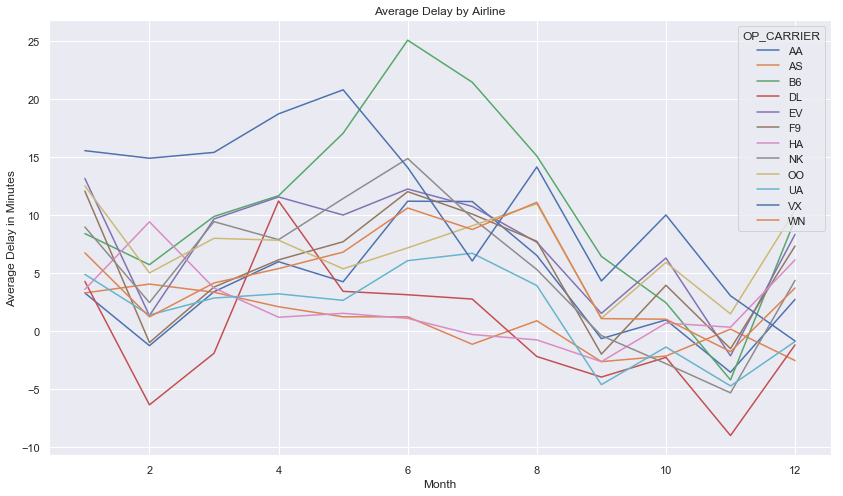

In [481]:
#What is the average arrival delay per month broken down by airline for all flights
optimized_df.groupby(["OP_CARRIER", "MONTH"])['ARR_DELAY'].mean().unstack('OP_CARRIER').plot()
plt.xlabel('Month')
plt.ylabel('Average Delay in Minutes')
plt.title('Average Delay by Airline')

In [471]:
airline_dict.get('AS')

'Alaska Airlines Inc. '

# Possible Hypotheses

H0: On average, busy airports tend to have longer delays, Ha: Busy airports have the same delays as non busy airports

H0: On average, busy regions tend to have longer delays, Ha: Busy regions tend to have same delays as non busy aiprots

In [270]:
#For regional calculation we'll set up a "radius" around the airport, for that we'll need a custom function
def radius(airport, miles):
    '''This function will return the absolute difference (in degrees) from the original location to the perimeter
    given the distance, and coordinates of the original location'''
    #based on ~69 miles per one degree of latitude
    coordinates = airport_loc.get(airport)
    #get the minimum and maximum latitudes, since latitude doesn't vary dramatically with distance away from equator
    #we can just compute the latitude variance by direct conversion of 69 miles per degree
    lat_var = miles / 69
    min_lat = coordinates[0] - lat_var
    max_lat = coordinates[0] + lat_var
    
    #longitude distance between degrees depends on the latitude, so we'll use the above computed latitudes to 
    #compute the variance in longitude
    long_min = miles / (math.cos(min_lat * math.pi / 180) * 69.172)  
    long_max = miles / (math.cos(max_lat * math.pi / 180) * 69.172)
    
    min_long = coordinates[1] - long_min
    max_long = coordinates[1] + long_max
    
    latitude = [min_lat, max_lat]
    longitude = [min_long, max_long]
    
    return latitude, longitude

In [321]:
radius('ATL', 50)[1][0]

83.56707427044617

In [331]:
def region_airports(airport, miles):
    '''This function takes airport code and distance around it as an input and
    returns a list of airport within the specified distance'''
    coordinates = radius(airport, miles)
    print(coordinates)
    airports = airport_location.copy()
    airports = airports[(airports.Latitude >= coordinates[0][0]) & (airports.Latitude <= coordinates[0][1]) &
                       (airports.Longitude >= coordinates[1][0]) & (airports.Longitude <= coordinates[1][1])]
    
    unique_list = airports['locationID'].unique()
    return unique_list

In [332]:
region_airports('ATL', 50)

([32.912062318840576, 34.36133768115942], [83.56707427044617, 85.30373974462347])


array(['GA15', 'GA61', '47A', '78GA', '8GA8', '6GA8', 'CTJ', '27GA',
       'VPC', '53GA', '4A4', '7GE5', 'RYY', 'PDK', 'FTY', 'ATL', 'CCO',
       'FFC', 'GA59', 'GA86', 'GA73', 'GA74', '4GA1', '2GA5', '36GA',
       'GA80', '07GA', '9A1', '9GE7', 'GA83', '4GA9', 'GA27', '6GA0',
       '88GA', '1GE5', 'GA68', 'GA75', 'GA29', '98GA', 'GA01', '62GA',
       '0GA6', 'GA98', 'LGC', 'GA44', 'LZU', '00GA', 'GA04', 'GE33',
       '6GA4', 'GA89', '1GA2', 'PUJ', '4GA6', '25GA', '0GE0', '02GE',
       'GA91', 'GA92', 'GA95', 'GA94', 'GA90', '19GA', 'GA76', '1GE3',
       '5GA7', 'GVL', '97GA', '80GA', '10GA', 'GA62', '6A2', '4GA7',
       '5GA5', '8GA6', '4A7', '0GA0', '6GA1', '5GA0', '1GA9', '67GA',
       'GA00', 'D73', 'GA06', '91GA', '2GA0', '2GE8', 'GA79', '26GA',
       '17GA', '2GA1', '89GE', 'MGE', '63GA', '77GA', '64GA', '2GA8',
       '29GA', '2GA9', '18GA', '4A0', '3GA0', '0GE4', '85GA', '0GA3',
       'OPN', 'GA31', 'RMG', '8GA1', '51GA', '8GA9', '3GA5', '81GA',
       '20GA', '5A9'

#  